In [1]:
# Run this cell first!
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling Yearly Average PEPM Costs For Huntington Hospital
The ultimate goal of this project is to build a model to predict the total cost of Huntington Hospital's self-insured health plan using the prior 36 months of data. More specifically, this model will be created to use the observed monthly PEPM costs to predict the average yearly PEPM cost for the following year to aid in the renewal process.

## Background
For any underwriting team calculating renewal rates can be a frustratingly difficult process. The main concern posed to underwriters is the volatility of claims experience data. Year-by-year and even month-by-month breakdowns of claims experience data yield often inconsistent numbers with frustratingly high variance. An experienced underwriter will take their industry knowledge and apply it to historical claims experience data to mitigate the impact of volatility on their renewal projections. This project aims to leverage Machine Learning models to aid the underwriter in the renewal projection process. As an aside, there is often a misconception surrounding Data Science that the point of creating Machine Learning models is to completely strip away the human element; however the model is merely performing a series of Linear Algebra calculations that must be made sense of within the greater context of the insurance space. Moreover, it is alongside expert feedback/insight that the model was created--it is inherently human as much as it is automated. In light of that, I want to thank both Kyle for providing that expert insight throughout the process and the entire BUAD team for helping me learn more about employer-sponsored health plans and the ins-and-outs of the space--without all of you this project could not have come togeether.

### Terminology


### Basic Methodology
Since our goal is to predict annual renewal rate increases, the granularity of the data will be yearly (i.e. each row will represent a **Renewal Year** and not a standard year). However, because Huntington Medical Group has data going back only to 2015, this doesn't give us many data points to use to train our model. To remedy this, we'll want to try and bootstrap the existing data to reconstruct the population from our sample and use the reconstructed population to train our model. *It is essential to note, however, that this method only works if the sample we are using to reconstruct the population is a representative sample.* Let's perform some EDA on the data to break this down.

### Note On Technical Specificity
Throughout this project there is an assumption that readers will have varying degrees of familiarity with the underlying statistical theory that justifies some of the approaches taken and certain programming techniques used throughout this analysis. As such, any methodology sections will include descriptions with varying levels of abstraction.

## Exploratory Data Analysis
### Data
We have an initial dataset to use. Let's load it in and perform some EDA on it to determine whether our bootstrapping method is appropriate. This data was generated from Huntington Medical Group's historical Monthly C&E Reports.

In [2]:
claims = pd.read_csv('Huntington Hospital C&E Data.csv')
claims['Total Expenses'] = claims['Adjusted Paid Claims'] + claims['Total Administration Fees']
claims['PMPM'] = claims['Total Expenses'] / claims['Member Count']
claims['PEPM'] = claims['Total Expenses'] / claims['EE Count']
claims

,Month,Year,Renewal Year,Domestic Medical Facility Claims (IP/OP),Non-Domestic Medical Claims (IP/OP),Total Hospital Medical Claims (IP/OP),Non-Hospital Medical Claims,Total Medical Claims,Rx Claims,Rx Rebates,Rx Performance Guarantee,Stop Loss Reimbursement,Adjusted Paid Claims,Total Administration Fees,Member Count,EE Count,Total Expenses,PMPM,PEPM
0,1,2015,0,414313.73,324468.71,738782.44,385900.53,1124682.97,397849.95,0.00,0.00,0.0,1522532.92,205802.2133,6146,2690,1.728335e+06,281.213006,642.503767
1,2,2015,0,539505.55,307763.94,847269.49,507899.40,1355168.89,503271.97,67540.50,0.00,0.0,1790900.36,206047.0000,6111,2716,1.996947e+06,326.779146,735.253078
2,3,2015,0,582799.17,272127.91,854927.08,539969.58,1394896.66,406481.14,0.00,0.00,0.0,1801377.80,204449.2367,6133,2706,2.005827e+06,327.054792,741.251677
3,4,2015,0,894533.91,253610.74,1148144.65,593447.65,1741592.30,533681.67,0.00,0.00,0.0,2275273.97,209692.2733,6113,2699,2.484966e+06,406.505193,920.698867
4,5,2015,0,732374.57,424912.54,1157287.11,419625.09,1576912.20,451070.89,66067.50,0.00,0.0,1961915.59,207418.0600,6114,2683,2.169334e+06,354.814140,808.547764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1,2022,7,501463.78,474951.54,976415.32,619224.78,1595640.10,603637.45,0.00,0.00,0.0,2199277.55,326785.6800,6622,3145,2.526063e+06,381.465302,803.199755
85,2,2022,7,702513.46,541335.00,1243848.46,1140214.23,2384062.69,650981.28,370485.73,0.00,0.0,2664558.24,324051.0600,6612,3092,2.988609e+06,451.997777,966.561869
86,3,2022,7,760937.71,588458.73,1349396.44,943089.50,2292485.94,788584.54,0.00,11435.00,0.0,3069635.48,326071.1600,6643,3111,3.395707e+06,511.170652,1091.516117
87,4,2022,7,579591.91,513879.57,1093471.48,963612.60,2057084.08,659029.75,0.00,0.00,0.0,2716113.83,326669.3600,6588,3108,3.042783e+06,461.867515,979.016470


**Features:**
1. **Month** *(int)* - int value corresponding to the Month (i.e. January - 1, February - 2, March - 3, etc.)
2. **Year** *(int)* - int value designating the Year
3. **Renewal Year** *(int)* - int value designating the Renewal Year (*Note: Renewal Year runs from May of the previous year to June of the next*)
4. **Domestic Medical Claims** *(float)* - floating point value corresponding to the total Medical Claims paid that were incurred within Huntington Medical Group
5. **Non-Domestic Medical Claims** *(float)* - floating point value corresponding to the total Medical Claims paid that were incurred outside Huntington Medical Group 
6. **Total Hospital Medical Claims** *(float)* - floating point value corresponding to the sum of **Domestic Medical Claims** and **Non-Domestic Medical Claims**
7. **Non-Hospital Medical Claims** *(float)* - floating point value corresponding to the total Medical Claims paid that were incurred at non-hospital facilities or for non-hospital services
8. **Total Medical Claims** *(float)* - floating point value corresponding to the total Medical Claims paid (i.e. sum of **Total Hospital Medical Claims** and **Non-Hospital Medical Claims**)
9. **Rx Claims** *(float)* - floating point value corresponding to the total Rx Claims paid
10. **Rx Rebates** *(float)* - floating point value corresponding to the total Rx Rebates
11. **Rx Performance Guarantee** *(float)* - floating point value corresponding to the total Rx Performance Guarantee
12. **Stop Loss Reimbursement** *(float)* - floating point value corresponding to the total Stop Loss Reimbursement issued
13. **Adjusted Paid Claims** *(float)* - floating point value corresponding to the total Adjusted Paid Claims (i.e. the difference between **Total Medical Claims** and the sum of **Rx Rebates**, **Rx Performance Guarantee**, and **Stop Loss Reimbusement**)
<br>
**Note: Remember that the granularity of this dataset is monthly**

In [3]:
def calculate_weighted_avg(data, renewal_year):
    '''
    Given data, data, and plan year, renewal_year, calculates
    the year's weighted average pepm cost
    -----
    Inputs:
    
    data (DataFrame) - DataFrame with data to calculate the year's
                       weighted average pepm cost
    
    renewal_year (int) - Int specifying the plan year to calculate
    -----
    Output:
    
    weighted_avg (float) - Calculated weighted average
    '''
    plan_year = data.sort_values(['Year', 'Month']).query('`Renewal Year` == @renewal_year')
    py_pepms = plan_year['PEPM'].values
    py_ee_counts = plan_year['EE Count'].values
    py_total_ee_count = sum(py_ee_counts)
    py_props = py_ee_counts / py_total_ee_count
    weighted_avg = sum(py_pepms * py_props)
    return weighted_avg

### Data Visualization
Let's do a deeper dive into `claims` and see whether our assumption is fair to make

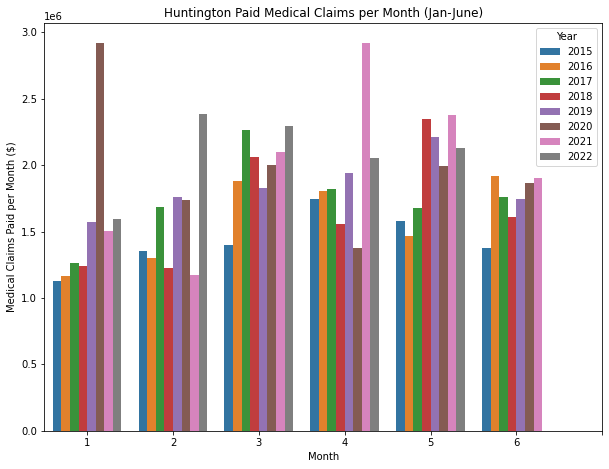

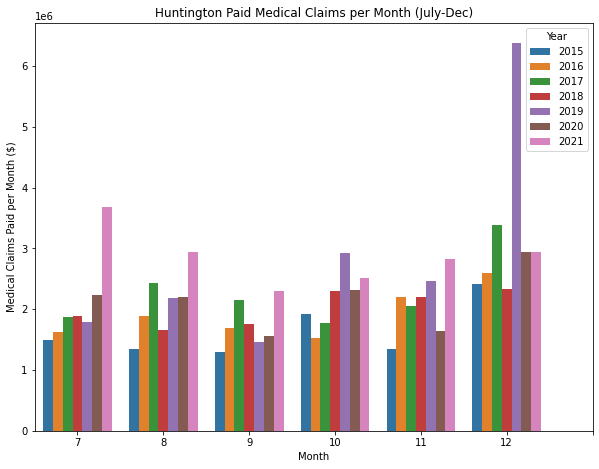

In [4]:
# Visualizing Total Medical Paid Claims by Month
plt.figure(figsize=(10, 7.5))
sns.barplot(data=claims.query('Month <= 6'), x='Month', y='Total Medical Claims', hue='Year')
plt.ylabel('Medical Claims Paid per Month ($)')
plt.xticks(np.arange(0, 7))
plt.title('Huntington Paid Medical Claims per Month (Jan-June)')
plt.show()

plt.figure(figsize=(10, 7.5))
sns.barplot(data=claims.query('Month > 6'), x='Month', y='Total Medical Claims', hue='Year')
plt.ylabel('Medical Claims Paid per Month ($)')
plt.xticks(np.arange(0, 7))
plt.title('Huntington Paid Medical Claims per Month (July-Dec)')
plt.show()

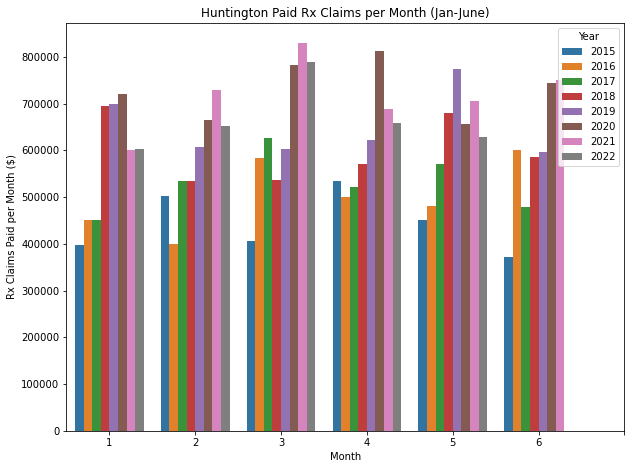

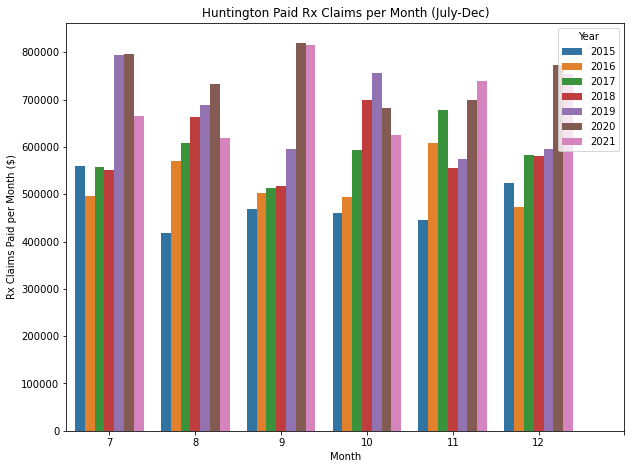

In [5]:
# Visualizing Total Rx Claims
plt.figure(figsize=(10, 7.5))
sns.barplot(data=claims.query('Month <= 6'), x='Month', y='Rx Claims', hue='Year')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.xticks(np.arange(0, 7))
plt.title('Huntington Paid Rx Claims per Month (Jan-June)')
plt.show()

plt.figure(figsize=(10, 7.5))
sns.barplot(data=claims.query('Month > 6'), x='Month', y='Rx Claims', hue='Year')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.xticks(np.arange(0, 7))
plt.title('Huntington Paid Rx Claims per Month (July-Dec)')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

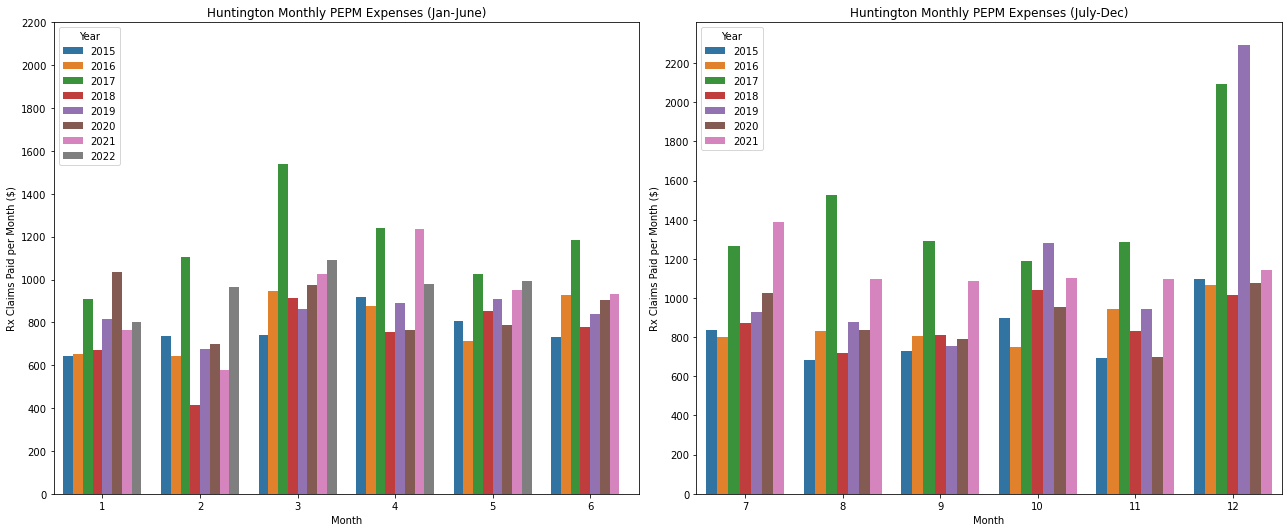

In [6]:
# Visualizing MONTHLY PMPM expenses
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.yticks(np.arange(0, 2400, 200))
plt.title('Huntington Monthly PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=claims.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.yticks(np.arange(0, 2400, 200))
plt.title('Huntington Monthly PEPM Expenses (July-Dec)')

plt.tight_layout()
plt.show

1/17, 1/20, 2/17, 2/18, **2/22**, 3/15, 4/17, 4/21, 6/17, 7/17, 7/21, 8/17, **8/21**, 9/17, **9/21**, 10/16, 10/19, 11/17, **11/21**, 12/17, 12/19

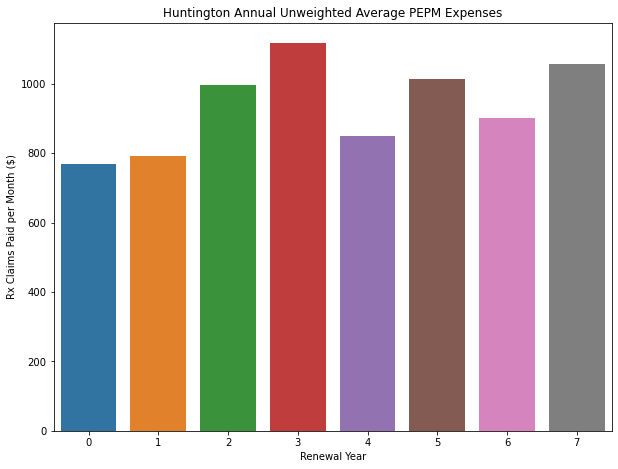

In [7]:
# Visualizing YEARLY PMPM expenses
plt.figure(figsize=(10, 7.5))
sns.barplot(data=claims.groupby('Renewal Year').mean().reset_index(), x='Renewal Year', y='PEPM')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.title('Huntington Annual Unweighted Average PEPM Expenses')
plt.show()

***Note: The values in the plot above are unweighted averages as they do not weight each month's PEPM expense by the proportion of Employee Months that are accrued. However, the EE Count remains relatively stable throughout and thus does not actually affect the overall shape of the plot.***

Let's breakdown these plots. The first two barplots visualize monthly Medical Claims paid by Year. Looking at these, we see one major takeaway:
* There appear to be some major outlying months (most obviously 1/20, 2/22, 4/21, 7/21, 12/19)

While this is interesting, it isn't really all that important since we really should be focusing on PMPM or PEPM values. <br> The second two barplots are nearly identical to the first two except that they visualize **Rx Claims**. Unsurprisingly, we see some similar trends:
* Values from more recent years seem abnormally high

Like before, this isn't really all that important. The next three plots are much more important as far as this project is concerned. The next two plots visualize Huntington Monthly PEPM Expenses by Year. Like the first four plots, there are certain months which are clearly outliers (most notably 2/17, 2/18, 3/17, 4/17, 4/18, 4/21, 5/17, 6/17, 7/17, 8/17, 9/17, 11/17, 12/17, and 12/19). Since we'll be wanting to Bootstrap using these values, we'll need to replace these outlier values. Below, we will be replacing these values with the average PEPM value between the PEPM expense for the same month of the previous year and the PEPM expense of the same month for the next year. **Should one of the outliers fall in the first or last year in the data, it will not be replaced**. For now, we will manually remove the outliers on Excel and reload the dataset back in.

In [8]:
stripped_claims = pd.read_csv('Huntington Medical Paid Claims Data Outlier Removed.csv')
stripped_claims

,Month,Year,Renewal Year,Domestic Medical Claims,Non-Domestic Medical Claims,Total Hospital Medical Claims,Non-Hospital Medical Claims,Total Medical Claims,Rx Claims,Rx Rebates,Rx Performance Guarantee,Stop Loss Reimbursement,Adjusted Paid Claims,Member Count,EE Count,PEPM,Unnamed: 16
0,1,2015,0,414313.73,324468.71,738782.44,385900.53,1124682.97,397849.95,0.00,0.00,0.0,1522532.92,6146,2690,565.997368,NaN
1,2,2015,0,539505.55,307763.94,847269.49,507899.40,1355168.89,503271.97,67540.50,0.00,0.0,1790900.36,6111,2716,659.388940,NaN
2,3,2015,0,582799.17,272127.91,854927.08,539969.58,1394896.66,406481.14,0.00,0.00,0.0,1801377.80,6133,2706,751.197614,NaN
3,4,2015,0,894533.91,253610.74,1148144.65,593447.65,1741592.30,533681.67,0.00,0.00,0.0,2275273.97,6113,2699,843.006287,NaN
4,5,2015,0,732374.57,424912.54,1157287.11,419625.09,1576912.20,451070.89,66067.50,0.00,0.0,1961915.59,6114,2683,731.239504,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1,2022,7,501463.78,474951.54,976415.32,619224.78,1595640.10,603637.45,0.00,0.00,0.0,2199277.55,6622,3145,699.293339,NaN
85,2,2022,7,702513.46,541335.00,1243848.46,1140214.23,2384062.69,650981.28,370485.73,0.00,0.0,2664558.24,6612,3092,861.758810,NaN
86,3,2022,7,760937.71,588458.73,1349396.44,943089.50,2292485.94,788584.54,0.00,11435.00,0.0,3069635.48,6643,3111,986.703787,NaN
87,4,2022,7,579591.91,513879.57,1093471.48,963612.60,2057084.08,659029.75,0.00,0.00,0.0,2716113.83,6588,3108,873.910499,NaN


Now let's recreate the visualizations from before:

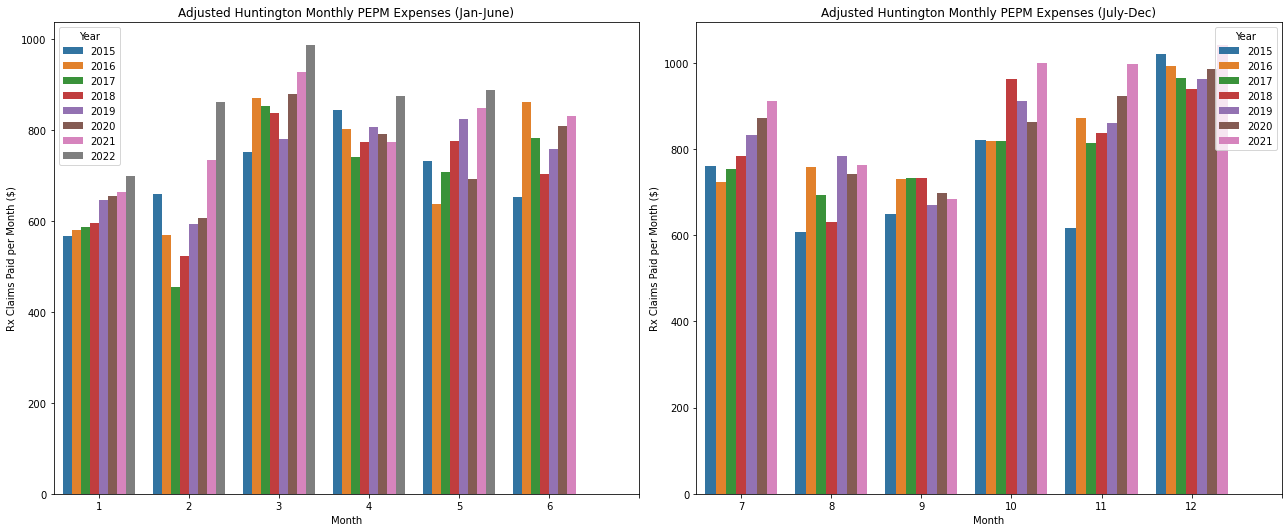

In [9]:
# Visualizing MONTHLY PMPM expenses
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=stripped_claims.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.xticks(np.arange(0, 7))
plt.title('Adjusted Huntington Monthly PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=stripped_claims.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.xticks(np.arange(0, 7))
plt.title('Adjusted Huntington Monthly PEPM Expenses (July-Dec)')

plt.tight_layout()
plt.show()

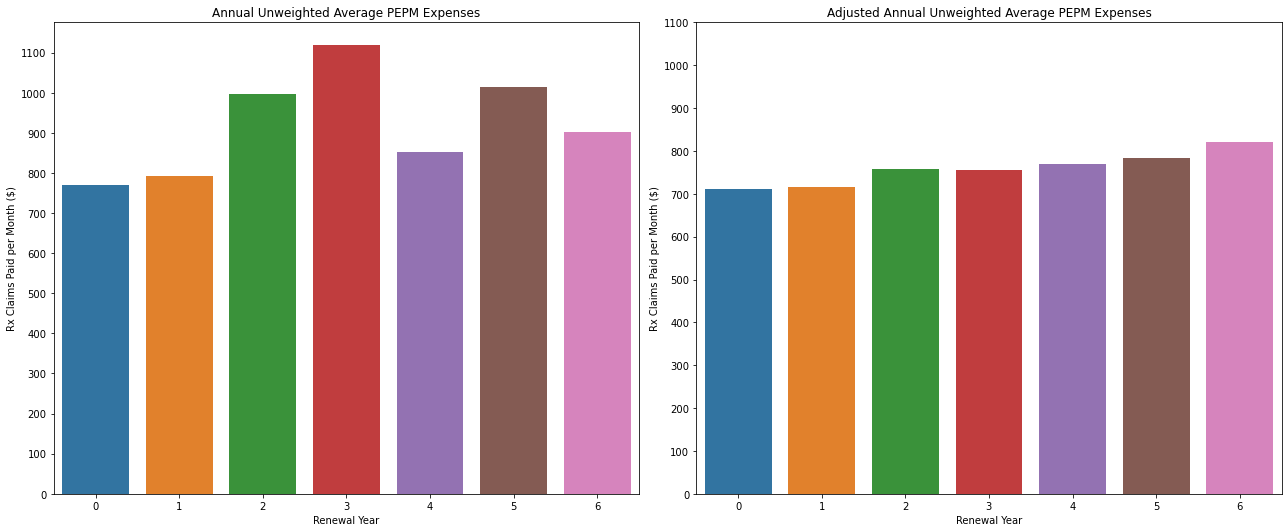

In [10]:
# Side-by-side comparison of actual and adjusted values
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.query('`Renewal Year` != 7').groupby('Renewal Year').mean().reset_index(), x='Renewal Year', y='PEPM')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.yticks(np.arange(0, 1200, 100))
plt.title('Annual Unweighted Average PEPM Expenses')

plt.subplot(1, 2, 2)
sns.barplot(data=stripped_claims.query('`Renewal Year` != 7').groupby('Renewal Year').mean().reset_index(), x='Renewal Year', y='PEPM')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.yticks(np.arange(0, 1200, 100))
plt.title('Adjusted Annual Unweighted Average PEPM Expenses')
plt.tight_layout()
plt.show()

***Note: The values in the plot above are unweighted averages as they do not weight each month's PEPM expense by the proportion of Employee Months that are accrued. However, the EE Count remains relatively stable throughout and thus does not actually affect the overall shape of the plot.***

The plot to the right look much better, we'll go ahead and use this fixed up data (`stripped_claims`) to train our model.

## Model Creation
Now that we've created a more representative dataset, we'll use it to train our model. Before we begin any actual programming, let's lay out a high level overview of the process we'll be following:
1. Generate 100 resamples per month
2. Strip resampled DataFrame to include just Month, Year, Renewal Year, and PEPM

In [11]:
# Generating resamples
resampled_months = pd.DataFrame(columns=['Month',
                                         'Year'])
for num in np.arange(1, 13):
    for i in np.arange(1000):
        each_month = stripped_claims.query('Month == @num and Year >= 2017')
        month = [num, num, num, num, num]
        year = [2017, 2018, 2019, 2020, 2021]
        df = {'Month': month, 'Year': year}
        resampled = pd.DataFrame(data=df)
        resample = each_month[['EE Count', 'PEPM']].sample(frac=1, replace=True, axis=0).reset_index().drop('index', axis=1)
        resampled['EE Count'] = resample['EE Count']
        resampled['PEPM'] = resample['PEPM']
        resampled_months = resampled_months.append(resampled)
resampled_months = resampled_months.reset_index().drop('index', axis=1).dropna()

# Further data transformations
def add_renewal_year(month, year):
    '''
    Function that returns a list of the corresponding Renewal Year for Huntington Medical Group
    -----
    Inputs:
    
    month (Python list) - Month column in resampled_months DataFrame
    
    year (Python list) - Year column in resampled_months DataFrame
    -----
    Output:
    
    renewal_year (Python list) - Corresponding renewal year column to be added to the
                                 resampled_months DataFrame
    '''
    renewal_year = []
    for i in np.arange(0, len(month)):
        if month[i] <= 5 and year[i] == 2015:
            renewal_year.append(0)
        elif month[i] >= 6 and year[i] == 2015:
            renewal_year.append(1)
        elif month[i] <=5 and year[i] == 2016:
            renewal_year.append(1)
        elif month[i] >= 6 and year[i] == 2016:
            renewal_year.append(2)
        elif month[i] <= 5 and year[i] == 2017:
            renewal_year.append(2)
        elif month[i] >= 6 and year[i] == 2017:
            renewal_year.append(3)
        elif month[i] <= 5 and year[i] == 2018:
            renewal_year.append(3)
        elif month[i] >= 6 and year[i] == 2018:
            renewal_year.append(4)
        elif month[i] <= 5 and year[i] == 2019:
            renewal_year.append(4)
        elif month[i] >= 6 and year[i] == 2019:
            renewal_year.append(5)
        elif month[i] <= 5 and year[i] == 2020:
            renewal_year.append(5)
        elif month[i] >= 6 and year[i] == 2020:
            renewal_year.append(6)
        elif month[i] <= 5 and year[i] == 2021:
            renewal_year.append(6)
        elif month[i] >= 6 and year[i] == 2021:
            renewal_year.append(7)
        elif month[i] <= 5 and year[i] == 2022:
            renewal_year.append(7)
        else:
            renewal_year.append(10)
    return renewal_year
resampled_months['Renewal Year'] = add_renewal_year(resampled_months['Month'].values, \
                                                    resampled_months['Year'].values)
resampled_months

,Month,Year,EE Count,PEPM,Renewal Year
0,1,2017,3145.0,699.293339,2
1,1,2018,3123.0,594.689216,3
2,1,2019,3145.0,699.293339,4
3,1,2020,3020.0,587.191524,5
4,1,2021,3123.0,594.689216,6
...,...,...,...,...,...
59995,12,2017,3160.0,985.160269,3
59996,12,2018,3107.0,940.140283,4
59997,12,2019,3116.0,966.030113,5
59998,12,2020,3116.0,966.030113,6


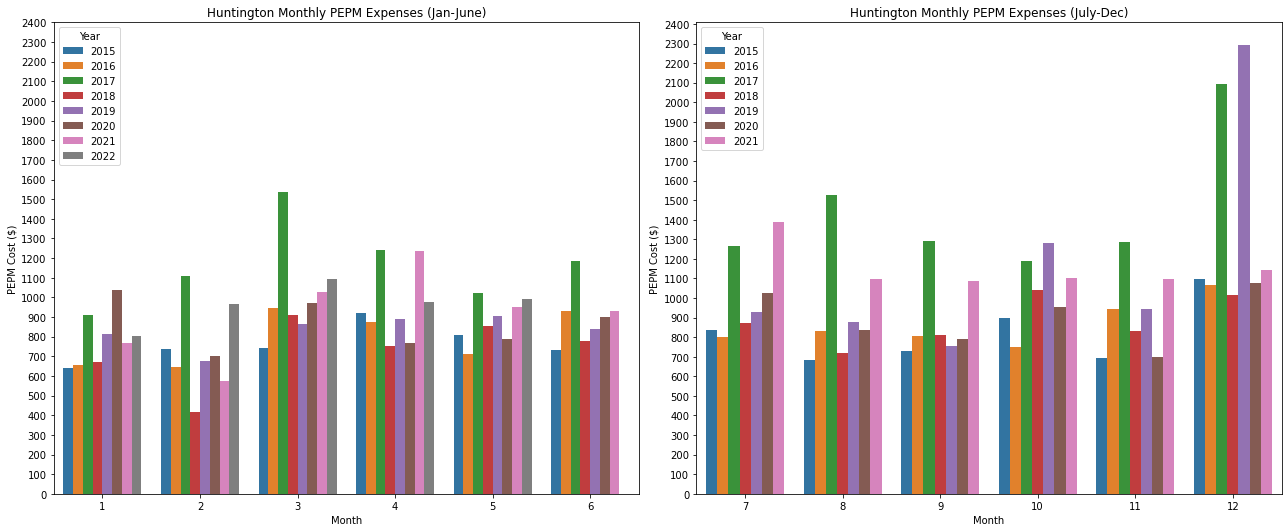

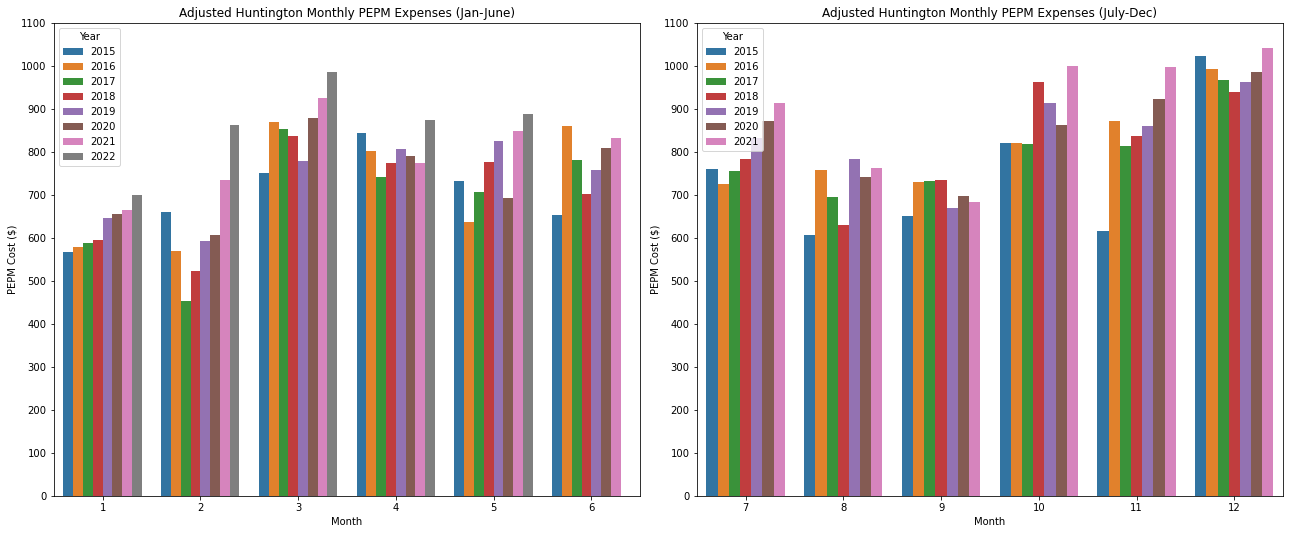

In [12]:
# Visualizing PEPM cost
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 2500, 100))
plt.title('Huntington Monthly PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=claims.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 2500, 100))
plt.title('Huntington Monthly PEPM Expenses (July-Dec)')

plt.tight_layout()
plt.show()

# Plot side-by-side adjusted monthly PEPM
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=stripped_claims.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 1200, 100))
plt.title('Adjusted Huntington Monthly PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=stripped_claims.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 1200, 100))
plt.title('Adjusted Huntington Monthly PEPM Expenses (July-Dec)')

plt.tight_layout(pad=1)
plt.show()

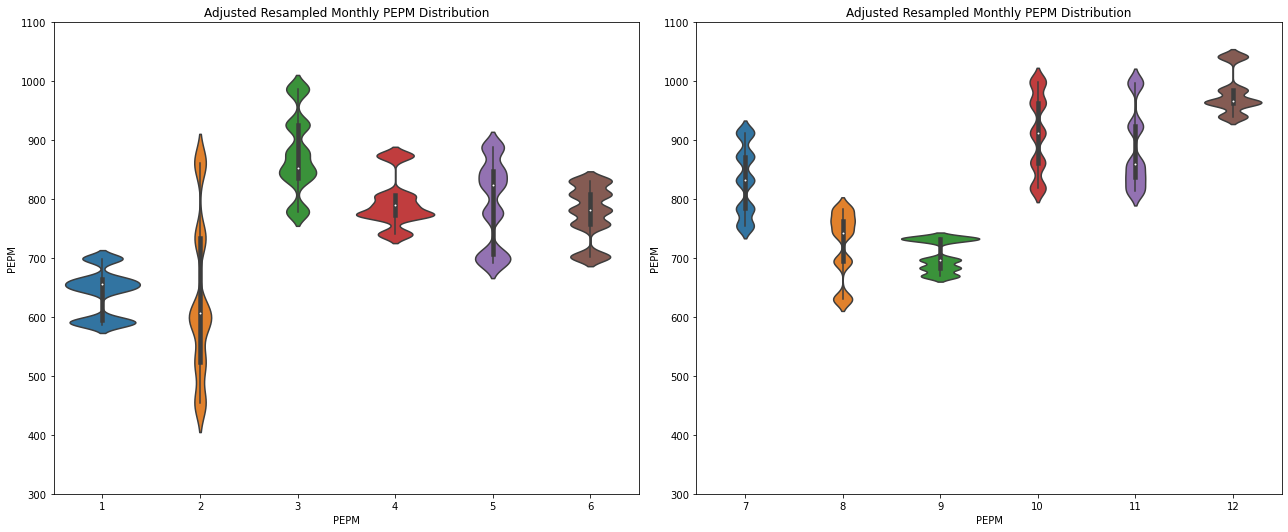

In [13]:
# Violin plots for January-June
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.violinplot(data=resampled_months.query('Month <= 6'), x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.yticks(np.arange(300, 1200, 100))
plt.title('Adjusted Resampled Monthly PEPM Distribution')

# Violin plots for July-December
plt.subplot(1, 2, 2)
sns.violinplot(data=resampled_months.query('Month > 6'), x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.yticks(np.arange(300, 1200, 100))
plt.title('Adjusted Resampled Monthly PEPM Distribution')

plt.tight_layout()
plt.show()

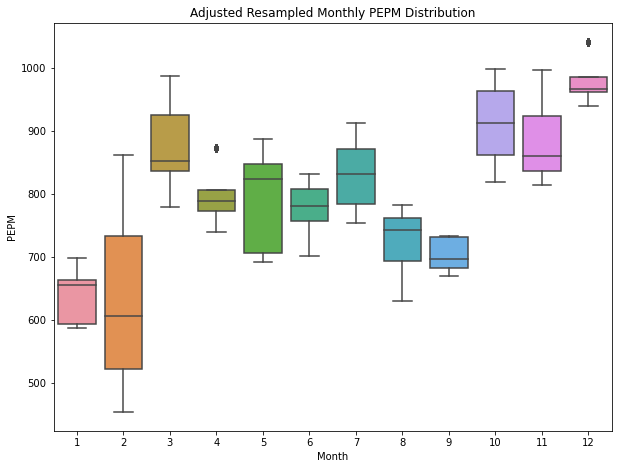

In [14]:
# Boxplot version of the above
plt.figure(figsize=(10, 7.5))
sns.boxplot(data=resampled_months, x='Month', y='PEPM')
plt.xlabel('Month')
plt.title('Adjusted Resampled Monthly PEPM Distribution')
plt.show()

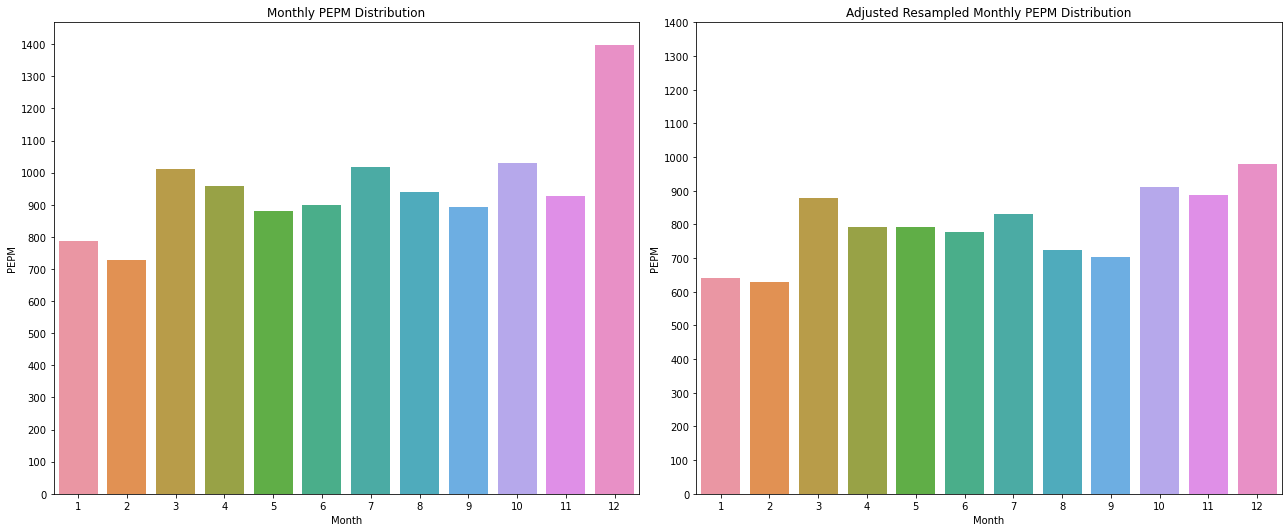

In [15]:
# Side-by-side mean monthly PEPM
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.groupby('Month').mean().reset_index(), x='Month', y='PEPM')
plt.xlabel('Month')
plt.yticks(np.arange(0, 1500, 100))
plt.title('Monthly PEPM Distribution')

# Violin plots for July-December
plt.subplot(1, 2, 2)
sns.barplot(data=resampled_months.groupby('Month').mean().reset_index(), x='Month', y='PEPM')
plt.xlabel('Month')
plt.yticks(np.arange(0, 1500, 100))
plt.title('Adjusted Resampled Monthly PEPM Distribution')

plt.tight_layout()
plt.show()

In [16]:
def resampled_year_avg_pepm(resampled_df, renewal_year, n):
    '''
    Extracts the year average PEPM cost from bootstrapped DataFrame resampled_df
    for the specified year renewal_year
    -----
    Input:
    
    resampled_df (DataFrame) - DataFrame with bootstrapped data
    
    renewal_year (int) - Int value specifying the renewal year to extract
    
    n (int) - Number of resamples
    -----
    Output:
    
    pepm_ryr (NumPy Array) - NumPy Array of length n (where n is the number of resamples)
                             with the yearly mean PEPM values
    '''
    ryr = resampled_df.sort_values(['Year', 'Month']) \
                      .query('`Renewal Year` == @renewal_year')
    pepm_arr_ryr = ryr['PEPM'].values
    ee_arr_ryr = ryr['EE Count'].values
    pepm_arr_ryr_split = np.split(pepm_arr_ryr, 12)
    ee_arr_ryr_split = np.split(ee_arr_ryr, 12)
    ee_sums = np.zeros(n)
    for i in range(len(ee_arr_ryr_split)):
        ee_sums += ee_arr_ryr_split[i]
    ee_props = [ee_arr_ryr_split[i] / ee_sums for i in range(len(ee_arr_ryr_split))]
    weighted_totals = [np.multiply(ee_props[i], pepm_arr_ryr_split[i]) for i in range(len(ee_props))]
    pepm_ryr = np.zeros(n)
    for i in range(len(weighted_totals)):
        pepm_ryr += weighted_totals[i]
    return pepm_ryr

p-value: 0.483


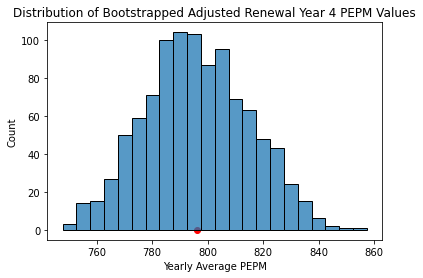

p-value: 0.498


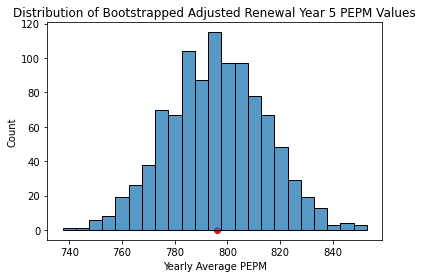

p-value: 0.481


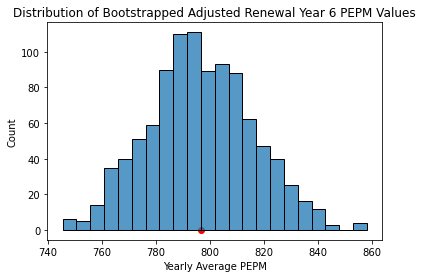

In [17]:
def plot_bootstrap_distributions(resampled_df, pepms, start_year):
    '''
    Plots the bootstrapped distribution of year average PEPM cost along
    with the actual observed value
    -----
    Inputs:
    
    resampled_df (DataFrame) - DataFrame from which to determine each renewal year's
                               weighted average PEPM cost
    
    pepms (Python List) - Nested Python List (or nested with List-like objects)
                          with the distributions to be plotted
                          
    start_year (int) - Int indicating the initial renewal year to be plotted
    -----
    Output:
    
    N/A
    '''
    observed_yearly_pepms = [calculate_weighted_avg(resampled_df, i) for i in np.arange(start_year, start_year + 3)]
    i = 0
    start = start_year
    for pepm in pepms:
        observed_year_pepm = observed_yearly_pepms[i]
        sns.histplot(data=pepm)
        plt.xlabel('Yearly Average PEPM')
        plt.title(f'Distribution of Bootstrapped Adjusted Renewal Year {start} PEPM Values')
        plt.scatter(observed_year_pepm, -0.01, color='red')
        print(f'p-value: {min(sum(pepms[i] >= observed_year_pepm) / len(pepms[i]), sum(pepms[i] <= observed_year_pepm) / len(pepms[i]))}')
        plt.show()
        i += 1
        start += 1
actual4, actual5, actual6 = [resampled_year_avg_pepm(resampled_months, i, 1000) for i in np.arange(4, 7)]
pepms = [actual4, actual5, actual6]
plot_bootstrap_distributions(resampled_months, pepms, 4)

Looking at the plots above and their corresponding p-values, we see that the bootsrapping process has both built an approximately normal distribution of PEPM values for each Renewal Year (Years 2-5 in our case) and has approximately rebuilt the population. We can say this because the observed averages are well within the distribution (i.e. the chance of mistakenly characterizing the observed value as statistically sigificant is high). Now we'll need to perform a series of data transformations to form the dataset we'll be using to train our model.

In [18]:
actual_pepm = resampled_year_avg_pepm(resampled_months, 6, 1000)

renewal_yr1 = np.split(resampled_months.query('`Renewal Year` == 3').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr2 = np.split(resampled_months.query('`Renewal Year` == 4').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr3 = np.split(resampled_months.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
design_matrix = pd.DataFrame(data={'Month 1': renewal_yr1[0], 'Month 2': renewal_yr1[1],
                                   'Month 3': renewal_yr1[2], 'Month 4': renewal_yr1[3],
                                   'Month 5': renewal_yr1[4], 'Month 6': renewal_yr1[5],
                                   'Month 7': renewal_yr1[6], 'Month 8': renewal_yr1[7],
                                   'Month 9': renewal_yr1[8], 'Month 10': renewal_yr1[9],
                                   'Month 11': renewal_yr1[10], 'Month 12': renewal_yr1[11],
                                   'Month 13': renewal_yr2[0], 'Month 14': renewal_yr2[1],
                                   'Month 15': renewal_yr2[2], 'Month 16': renewal_yr2[3],
                                   'Month 17': renewal_yr2[4], 'Month 18': renewal_yr2[5],
                                   'Month 19': renewal_yr2[6], 'Month 20': renewal_yr2[7],
                                   'Month 21': renewal_yr2[8], 'Month 22': renewal_yr2[9],
                                   'Month 23': renewal_yr2[10], 'Month 24':renewal_yr2[11],
                                   'Month 25': renewal_yr3[0], 'Month 26': renewal_yr3[1],
                                   'Month 27': renewal_yr3[2], 'Month 28': renewal_yr3[3],
                                   'Month 29': renewal_yr3[4], 'Month 30': renewal_yr3[5],
                                   'Month 31': renewal_yr3[6], 'Month 32': renewal_yr3[7],
                                   'Month 33': renewal_yr3[8], 'Month 34': renewal_yr3[9],
                                   'Month 35': renewal_yr3[10], 'Month 36': renewal_yr3[11],
                                   'Following Year Average PEPM': actual_pepm})
design_matrix

,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,...,Month 28,Month 29,Month 30,Month 31,Month 32,Month 33,Month 34,Month 35,Month 36,Following Year Average PEPM
0,702.351556,784.289329,694.596059,683.296007,963.136584,923.611905,962.650276,594.689216,592.667177,879.691395,...,697.144312,963.136584,860.013687,940.140283,587.191524,523.258018,879.691395,806.582724,692.180479,767.162750
1,831.153148,832.004270,694.596059,734.055902,912.600062,836.849738,962.650276,699.293339,606.286068,986.703787,...,734.055902,999.040080,860.013687,940.140283,594.689216,523.258018,879.691395,806.582724,888.158713,789.350229
2,831.153148,872.348275,742.539715,697.144312,862.063540,836.849738,1041.966809,664.330413,734.022439,879.691395,...,731.902108,862.063540,997.168487,1041.966809,646.340514,453.848858,852.756765,740.408780,888.158713,781.414810
3,808.097704,754.368547,783.151979,731.902108,818.841053,813.685789,966.030113,699.293339,734.022439,926.147536,...,731.902108,999.040080,836.849738,962.650276,699.293339,453.848858,926.147536,873.910499,776.423408,788.483822
4,781.432442,832.004270,742.539715,697.144312,818.841053,923.611905,1041.966809,664.330413,523.258018,879.691395,...,697.144312,963.136584,860.013687,940.140283,664.330413,606.286068,778.846267,806.582724,692.180479,806.934392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,757.194834,912.692280,630.378131,731.902108,862.063540,997.168487,985.160269,646.340514,592.667177,836.322759,...,734.055902,912.600062,860.013687,966.030113,664.330413,453.848858,778.846267,806.582724,888.158713,769.801364
996,781.432442,912.692280,762.845847,697.144312,912.600062,836.849738,985.160269,655.335464,453.848858,879.691395,...,731.902108,862.063540,923.611905,962.650276,699.293339,592.667177,986.703787,789.862151,776.423408,785.306847
997,781.432442,912.692280,783.151979,734.055902,912.600062,997.168487,966.030113,594.689216,592.667177,778.846267,...,669.447702,999.040080,813.685789,962.650276,664.330413,592.667177,852.756765,873.910499,888.158713,797.299688
998,702.351556,832.004270,694.596059,683.296007,963.136584,997.168487,966.030113,655.335464,861.758810,778.846267,...,697.144312,818.841053,836.849738,985.160269,699.293339,453.848858,986.703787,773.495752,824.151838,804.841631


## Training the Model
Now that our design matrix has been created we'll import in `sklearn` to be able to create and train a Linear Regression Model to predict average PEPM cost for the year based on the past 36 months of PEPM values.

Validation RMSE: 20.15648058289174
Test RMSE: 21.839865285264768
766.5359508727443
827.5768487085096
Alpha: 27.30614535842145


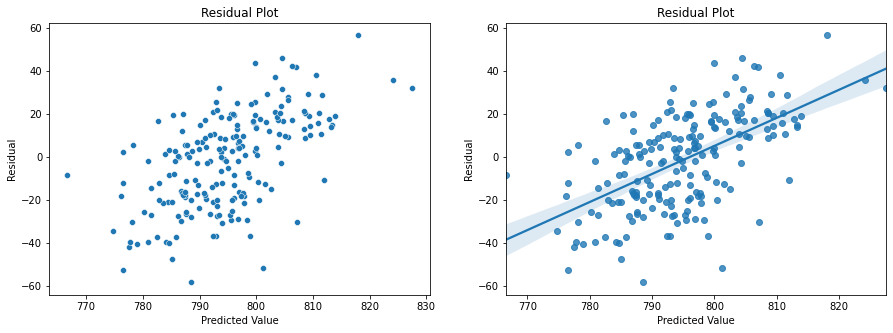

Correlation: 0.5793940035041283


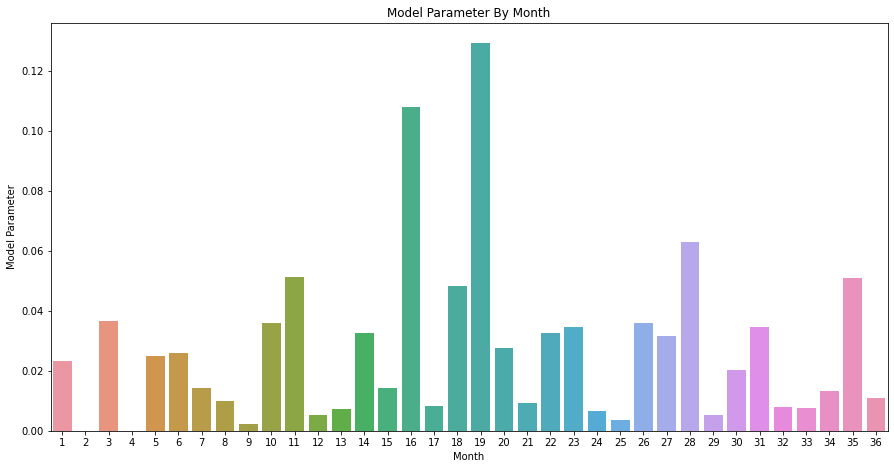

In [19]:
# Model Selection
from sklearn import model_selection, linear_model

# Split into train and test sets
X = design_matrix.drop('Following Year Average PEPM', axis=1)
Y = design_matrix[['Following Year Average PEPM']]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2)


# Train and fit the model
model = linear_model.LassoCV(eps=0.0000001, n_alphas=1000, fit_intercept=False, max_iter=100000, cv=10)
model.fit(X_train, Y_train.values.flatten())

# Model validation
validation_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
model_validation_error = (np.mean((validation_predictions - Y_train.values.flatten()) ** 2)) ** 0.5
model_test_error = (np.mean((test_predictions - Y_test.values.flatten()) ** 2)) ** 0.5
print(f'Validation RMSE: {model_validation_error}')
print(f'Test RMSE: {model_test_error}')
print(min(test_predictions.flatten()))
print(max(test_predictions.flatten()))
print(f'Alpha: {model.alpha_}')

# Plotting the residuals
residuals = test_predictions.flatten() - Y_test.values.flatten()
residuals_df = pd.DataFrame(data={'Predicted Value': test_predictions.flatten(), 'Residual': residuals})

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=residuals_df, x='Predicted Value', y='Residual')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.regplot(data=residuals_df, x='Predicted Value', y='Residual')
plt.title('Residual Plot')

plt.show()
print(f'Correlation: {residuals_df.corr()["Residual"].values[0]}')

# Plotting model parameters
model_parameters = model.coef_.flatten()
coefficients_df = pd.DataFrame(data={'Month': np.arange(1, 37), 'Coefficients': model_parameters})

plt.figure(figsize=(15, 7.5))
sns.barplot(data=coefficients_df, x='Month', y='Coefficients')
plt.xlabel('Month')
plt.ylabel('Model Parameter')
plt.title('Model Parameter By Month')
plt.show()

In [20]:
pd.DataFrame(data={'Test Predictions': test_predictions.flatten(), 'Actual Values': Y_test.values.flatten()})

,Test Predictions,Actual Values
0,794.271666,789.969416
1,804.314264,807.256139
2,786.725896,802.454960
3,799.696923,774.137710
4,805.621886,796.198833
...,...,...
195,791.184931,786.499783
196,813.192846,799.295040
197,811.068896,790.644589
198,776.456757,829.189551


Test RMSE: 20.504216901079054
Min: 766.5359508727443
Max: 827.5768487085096


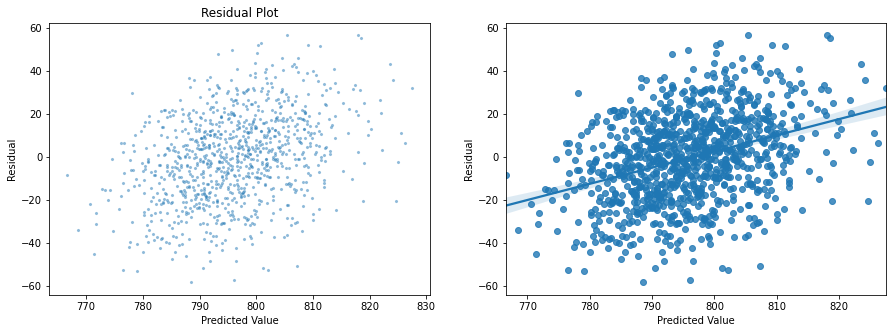

Correlation: 0.35564533258581843


In [21]:
# Years 3, 4, and 5 predicting 6
Y_test3 = resampled_year_avg_pepm(resampled_months, 6, 1000)

renewal_yr3 = np.split(resampled_months.query('`Renewal Year` == 3').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr4 = np.split(resampled_months.query('`Renewal Year` == 4').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr5 = np.split(resampled_months.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
design_matrix3 = pd.DataFrame(data={'Month 1': renewal_yr3[0], 'Month 2': renewal_yr3[1],
                                   'Month 3': renewal_yr3[2], 'Month 4': renewal_yr3[3],
                                   'Month 5': renewal_yr3[4], 'Month 6': renewal_yr3[5],
                                   'Month 7': renewal_yr3[6], 'Month 8': renewal_yr3[7],
                                   'Month 9': renewal_yr3[8], 'Month 10': renewal_yr3[9],
                                   'Month 11': renewal_yr3[10], 'Month 12': renewal_yr3[11],
                                   'Month 13': renewal_yr4[0], 'Month 14': renewal_yr4[1],
                                   'Month 15': renewal_yr4[2], 'Month 16': renewal_yr4[3],
                                   'Month 17': renewal_yr4[4], 'Month 18': renewal_yr4[5],
                                   'Month 19': renewal_yr4[6], 'Month 20': renewal_yr4[7],
                                   'Month 21': renewal_yr4[8], 'Month 22': renewal_yr4[9],
                                   'Month 23': renewal_yr4[10], 'Month 24':renewal_yr4[11],
                                   'Month 25': renewal_yr5[0], 'Month 26': renewal_yr5[1],
                                   'Month 27': renewal_yr5[2], 'Month 28': renewal_yr5[3],
                                   'Month 29': renewal_yr5[4], 'Month 30': renewal_yr5[5],
                                   'Month 31': renewal_yr5[6], 'Month 32': renewal_yr5[7],
                                   'Month 33': renewal_yr5[8], 'Month 34': renewal_yr5[9],
                                   'Month 35': renewal_yr5[10], 'Month 36': renewal_yr5[11]})

test_predictions = model.predict(design_matrix3)
model_test_error = (np.mean((test_predictions - Y_test3.flatten()) ** 2)) ** 0.5
print(f'Test RMSE: {model_test_error}')
print(f'Min: {min(test_predictions.flatten())}')
print(f'Max: {max(test_predictions.flatten())}')
pd.DataFrame(data={'Test Predictions': test_predictions.flatten(), 'Actual Values':Y_test3.flatten()})

residuals = test_predictions.flatten() - Y_test3.flatten()
residuals_df = pd.DataFrame(data={'Predicted Value': test_predictions.flatten(), 'Residual': residuals})

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=residuals_df, x='Predicted Value', y='Residual', s=10, alpha=0.5)
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.regplot(data=residuals_df, x= 'Predicted Value', y='Residual')
plt.show()
print(f'Correlation: {residuals_df.corr()["Residual"].values[0]}')

## Prediction Task

In [22]:
# Transform data
prediction_data = pd.read_csv('2019-2022 Data For Prediction.csv')
prediction_data['Total Expenses'] = prediction_data['Adjusted Paid Claims'] + prediction_data['Total Administration Fees']
prediction_data['PMPM'] = prediction_data['Total Expenses'] / prediction_data['Member Count']
prediction_data['PEPM'] = prediction_data['Total Expenses'] / prediction_data['EE Count']

renewal_yr5 = np.split(prediction_data.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr6 = np.split(prediction_data.query('`Renewal Year` == 6').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr7 = np.split(prediction_data.query('`Renewal Year` == 7').sort_values(['Year', 'Month'])['PEPM'].values, 12)
prediction_matrix = pd.DataFrame(data={'Month 1': renewal_yr5[0], 'Month 2': renewal_yr5[1],
                                       'Month 3': renewal_yr5[2], 'Month 4': renewal_yr5[3],
                                       'Month 5': renewal_yr5[4], 'Month 6': renewal_yr5[5],
                                       'Month 7': renewal_yr5[6], 'Month 8': renewal_yr5[7],
                                       'Month 9': renewal_yr5[8], 'Month 10': renewal_yr5[9],
                                       'Month 11': renewal_yr5[10], 'Month 12': renewal_yr5[11],
                                       'Month 13': renewal_yr6[0], 'Month 14': renewal_yr6[1],
                                       'Month 15': renewal_yr6[2], 'Month 16': renewal_yr6[3],
                                       'Month 17': renewal_yr6[4], 'Month 18': renewal_yr6[5],
                                       'Month 19': renewal_yr6[6], 'Month 20': renewal_yr6[7],
                                       'Month 21': renewal_yr6[8], 'Month 22': renewal_yr6[9],
                                       'Month 23': renewal_yr6[10], 'Month 24':renewal_yr6[11],
                                       'Month 25': renewal_yr7[0], 'Month 26': renewal_yr7[1],
                                       'Month 27': renewal_yr7[2], 'Month 28': renewal_yr7[3],
                                       'Month 29': renewal_yr7[4], 'Month 30': renewal_yr7[5],
                                       'Month 31': renewal_yr7[6], 'Month 32': renewal_yr7[7],
                                       'Month 33': renewal_yr7[8], 'Month 34': renewal_yr7[9],
                                       'Month 35': renewal_yr7[10], 'Month 36': renewal_yr7[11]})

prediction = model.predict(prediction_matrix).flatten()[0]
prediction.flatten()[0]

970.5757914077393

In [23]:
# Transform data
comparison_data = pd.read_csv('2018-2021 Data For Prediction.csv')
comparison_data['Total Expenses'] = comparison_data['Adjusted Paid Claims'] + comparison_data['Total Administration Fees']
comparison_data['PMPM'] = comparison_data['Total Expenses'] / comparison_data['Member Count']
comparison_data['PEPM'] = comparison_data['Total Expenses'] / comparison_data['EE Count']


# Comparing Models
renewal_yr4 = np.split(comparison_data.query('`Renewal Year` == 4').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr5 = np.split(comparison_data.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr6 = np.split(comparison_data.query('`Renewal Year` == 6').sort_values(['Year', 'Month'])['PEPM'].values, 12)
comparison_matrix = pd.DataFrame(data={'Month 1': renewal_yr4[0], 'Month 2': renewal_yr4[1],
                                       'Month 3': renewal_yr4[2], 'Month 4': renewal_yr4[3],
                                       'Month 5': renewal_yr4[4], 'Month 6': renewal_yr4[5],
                                       'Month 7': renewal_yr4[6], 'Month 8': renewal_yr4[7],
                                       'Month 9': renewal_yr4[8], 'Month 10': renewal_yr4[9],
                                       'Month 11': renewal_yr4[10], 'Month 12': renewal_yr4[11],
                                       'Month 13': renewal_yr5[0], 'Month 14': renewal_yr5[1],
                                       'Month 15': renewal_yr5[2], 'Month 16': renewal_yr5[3],
                                       'Month 17': renewal_yr5[4], 'Month 18': renewal_yr5[5],
                                       'Month 19': renewal_yr5[6], 'Month 20': renewal_yr5[7],
                                       'Month 21': renewal_yr5[8], 'Month 22': renewal_yr5[9],
                                       'Month 23': renewal_yr5[10], 'Month 24':renewal_yr5[11],
                                       'Month 25': renewal_yr6[0], 'Month 26': renewal_yr6[1],
                                       'Month 27': renewal_yr6[2], 'Month 28': renewal_yr6[3],
                                       'Month 29': renewal_yr6[4], 'Month 30': renewal_yr6[5],
                                       'Month 31': renewal_yr6[6], 'Month 32': renewal_yr6[7],
                                       'Month 33': renewal_yr6[8], 'Month 34': renewal_yr6[9],
                                       'Month 35': renewal_yr6[10], 'Month 36': renewal_yr6[11]})

comparison = model.predict(comparison_matrix).flatten()[0]
comparison.flatten()[0]

1048.9423580521752

## Secondary Model

In [24]:
adjusted = pd.read_csv('Huntington Hospital C&E Data Outliers Removed.csv')
adjusted

,Month,Year,Renewal Year,Domestic Medical Facility Claims (IP/OP),Non-Domestic Medical Claims (IP/OP),Total Hospital Medical Claims (IP/OP),Non-Hospital Medical Claims,Total Medical Claims,Rx Claims,Rx Rebates,Rx Performance Guarantee,Stop Loss Reimbursement,Adjusted Paid Claims,Total Administration Fees,Member Count,EE Count,PEPM
0,1,2015,0,414313.73,324468.71,738782.44,385900.53,1124682.97,397849.95,0.00,0.00,0.0,1522532.92,205802.2133,6146,2690,642.503767
1,2,2015,0,539505.55,307763.94,847269.49,507899.40,1355168.89,503271.97,67540.50,0.00,0.0,1790900.36,206047.0000,6111,2716,735.253078
2,3,2015,0,582799.17,272127.91,854927.08,539969.58,1394896.66,406481.14,0.00,0.00,0.0,1801377.80,204449.2367,6133,2706,827.975973
3,4,2015,0,894533.91,253610.74,1148144.65,593447.65,1741592.30,533681.67,0.00,0.00,0.0,2275273.97,209692.2733,6113,2699,920.698868
4,5,2015,0,732374.57,424912.54,1157287.11,419625.09,1576912.20,451070.89,66067.50,0.00,0.0,1961915.59,207418.0600,6114,2683,808.547764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1,2022,7,501463.78,474951.54,976415.32,619224.78,1595640.10,603637.45,0.00,0.00,0.0,2199277.55,326785.6800,6622,3145,803.199755
85,2,2022,7,702513.46,541335.00,1243848.46,1140214.23,2384062.69,650981.28,370485.73,0.00,0.0,2664558.24,324051.0600,6612,3092,699.823828
86,3,2022,7,760937.71,588458.73,1349396.44,943089.50,2292485.94,788584.54,0.00,11435.00,0.0,3069635.48,326071.1600,6643,3111,1091.516117
87,4,2022,7,579591.91,513879.57,1093471.48,963612.60,2057084.08,659029.75,0.00,0.00,0.0,2716113.83,326669.3600,6588,3108,979.016470


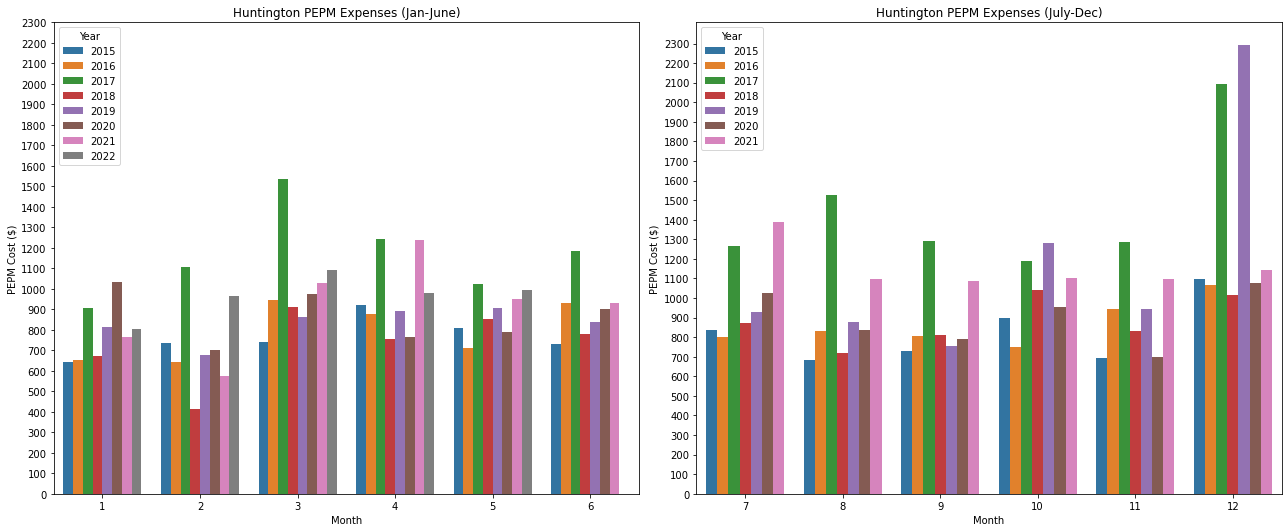

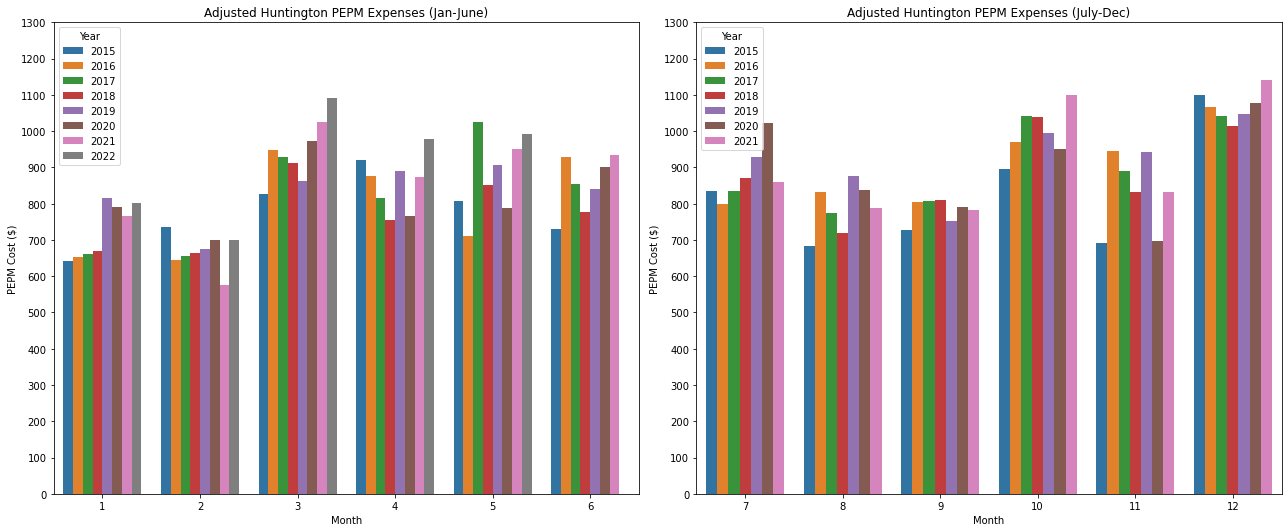

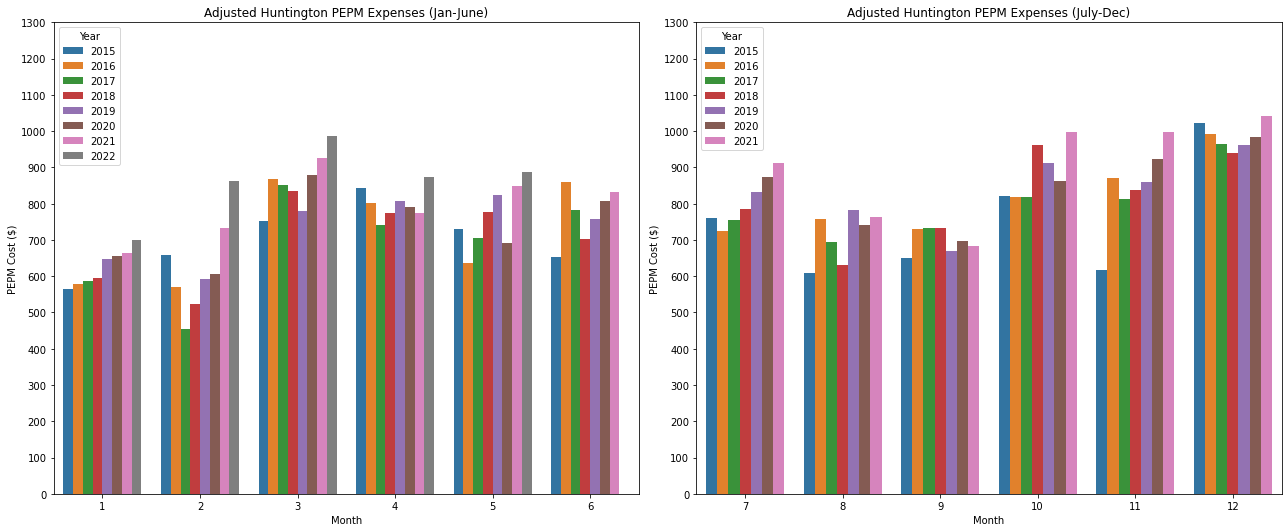

In [25]:
# Visualizing monthly PEPM expenses
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 2400, 100))
plt.title('Huntington PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=claims.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 2400, 100))
plt.title('Huntington PEPM Expenses (July-Dec)')

plt.tight_layout()
plt.show()

# Visualizing adjusted monthly PEPM expenses
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=adjusted.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 1400, 100))
plt.title('Adjusted Huntington PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=adjusted.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 1400, 100))
plt.title('Adjusted Huntington PEPM Expenses (July-Dec)')

plt.tight_layout()
plt.show()

# Visualizing adjusted monthly PEPM expenses
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=stripped_claims.query('Month <= 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 1400, 100))
plt.title('Adjusted Huntington PEPM Expenses (Jan-June)')

plt.subplot(1, 2, 2)
sns.barplot(data=stripped_claims.query('Month > 6'), x='Month', y='PEPM', hue='Year')
plt.ylabel('PEPM Cost ($)')
plt.yticks(np.arange(0, 1400, 100))
plt.title('Adjusted Huntington PEPM Expenses (July-Dec)')

plt.tight_layout()
plt.show()

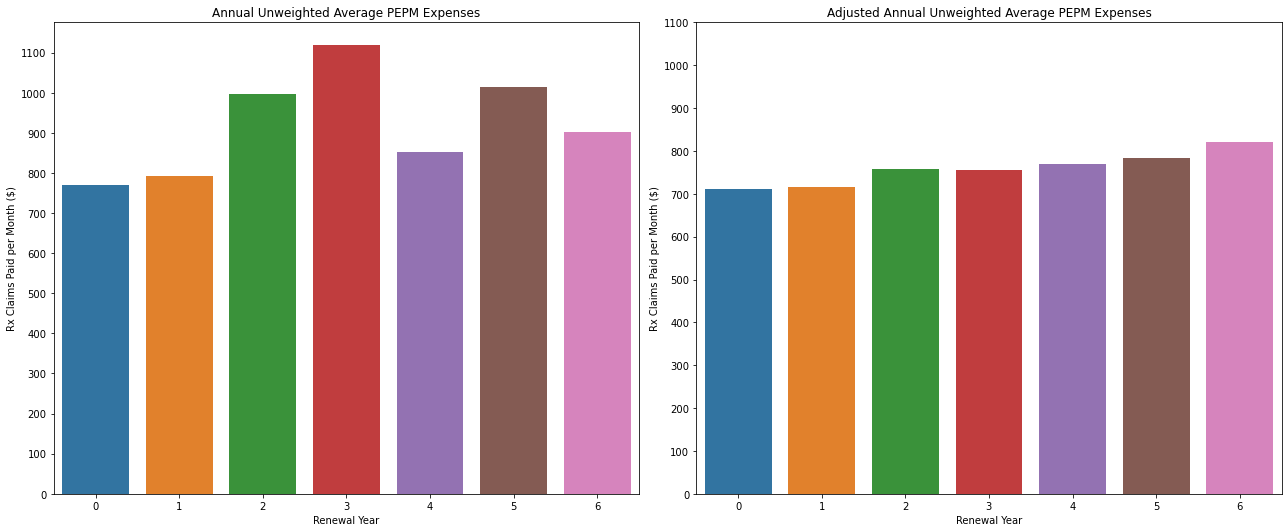

In [26]:
# Side-by-side comparison of actual and adjusted values
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.query('`Renewal Year` != 7').groupby('Renewal Year').mean().reset_index(), x='Renewal Year', y='PEPM')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.yticks(np.arange(0, 1200, 100))
plt.title('Annual Unweighted Average PEPM Expenses')

plt.subplot(1, 2, 2)
sns.barplot(data=stripped_claims.query('`Renewal Year` != 7').groupby('Renewal Year').mean().reset_index(), x='Renewal Year', y='PEPM')
plt.ylabel('Rx Claims Paid per Month ($)')
plt.yticks(np.arange(0, 1200, 100))
plt.title('Adjusted Annual Unweighted Average PEPM Expenses')
plt.tight_layout()
plt.show()

In [27]:
# Generating resamples
resampled_months2 = pd.DataFrame(columns=['Month',
                                         'Year'])
for num in np.arange(1, 13):
    for i in np.arange(1000):
        each_month = adjusted.query('Month == @num and Year >= 2017')
        month = [num, num, num, num, num]
        year = [2017, 2018, 2019, 2020, 2021]
        df = {'Month': month, 'Year': year}
        resampled = pd.DataFrame(data=df)
        resample = each_month[['EE Count', 'PEPM']].sample(frac=1, replace=True, axis=0).reset_index().drop('index', axis=1)
        resampled['EE Count'] = resample['EE Count']
        resampled['PEPM'] = resample['PEPM']
        resampled_months2 = resampled_months2.append(resampled)
resampled_months2 = resampled_months2.reset_index().drop('index', axis=1).dropna()

# Further data transformations
resampled_months2['Renewal Year'] = add_renewal_year(resampled_months2['Month'].values, \
                                                     resampled_months2['Year'].values)
resampled_months2

,Month,Year,EE Count,PEPM,Renewal Year
0,1,2017,3164.0,790.627938,2
1,1,2018,3174.0,765.788173,3
2,1,2019,3164.0,790.627938,4
3,1,2020,3108.0,815.467703,5
4,1,2021,3164.0,790.627938,6
...,...,...,...,...,...
59995,12,2017,3128.0,1142.402189,3
59996,12,2018,3055.0,1046.048491,4
59997,12,2019,3128.0,1142.402189,5
59998,12,2020,3160.0,1076.422051,6


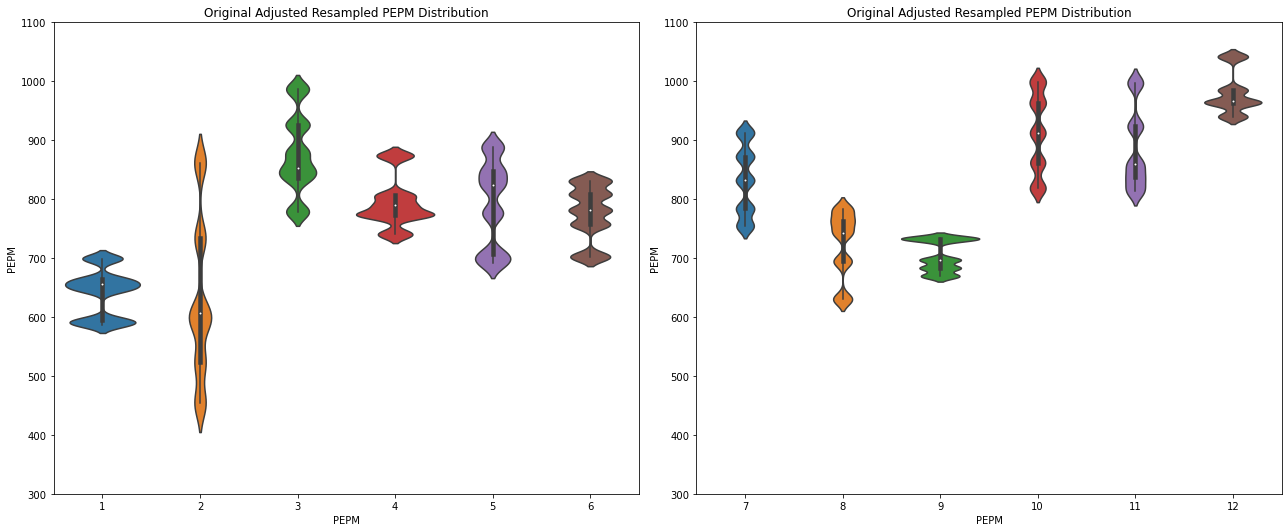

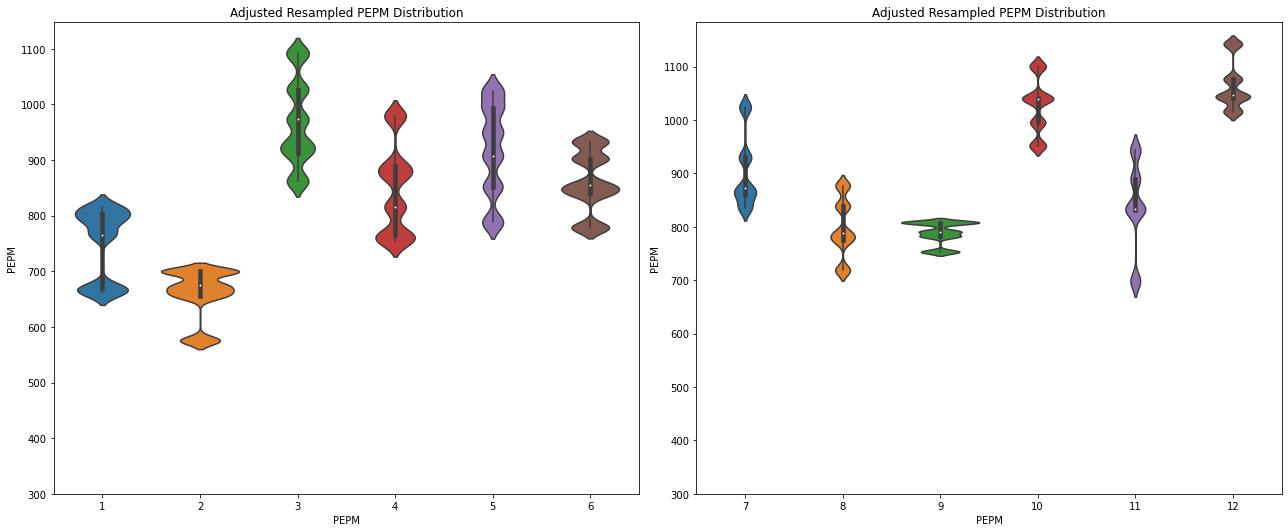

In [28]:
# Original violin plots for January-June
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.violinplot(data=resampled_months.query('Month <= 6'), x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.yticks(np.arange(300, 1200, 100))
plt.title('Original Adjusted Resampled PEPM Distribution')

# Original violin plots for July-December
plt.subplot(1, 2, 2)
sns.violinplot(data=resampled_months.query('Month > 6'), x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.yticks(np.arange(300, 1200, 100))
plt.title('Original Adjusted Resampled PEPM Distribution')

plt.tight_layout()
plt.show()

# Violin plots for January-June
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.violinplot(data=resampled_months2.query('Month <= 6'), x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.yticks(np.arange(300, 1200, 100))
plt.title('Adjusted Resampled PEPM Distribution')

# Violin plots for July-December
plt.subplot(1, 2, 2)
sns.violinplot(data=resampled_months2.query('Month > 6'), x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.yticks(np.arange(300, 1200, 100))
plt.title('Adjusted Resampled PEPM Distribution')

plt.tight_layout()
plt.show()

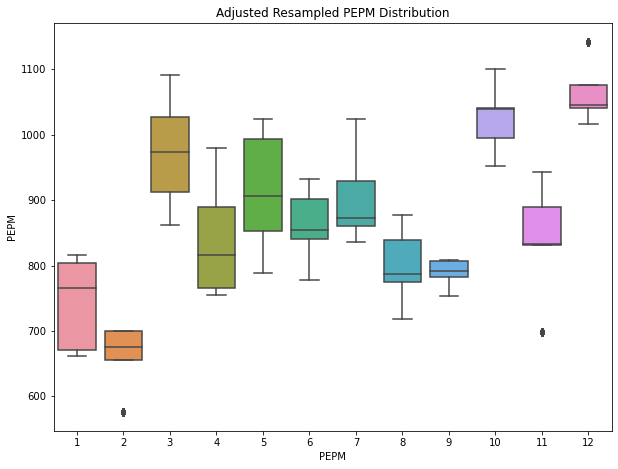

In [29]:
# Boxplot version of the above
plt.figure(figsize=(10, 7.5))
sns.boxplot(data=resampled_months2, x='Month', y='PEPM')
plt.xlabel('PEPM')
plt.title('Adjusted Resampled PEPM Distribution')
plt.show()

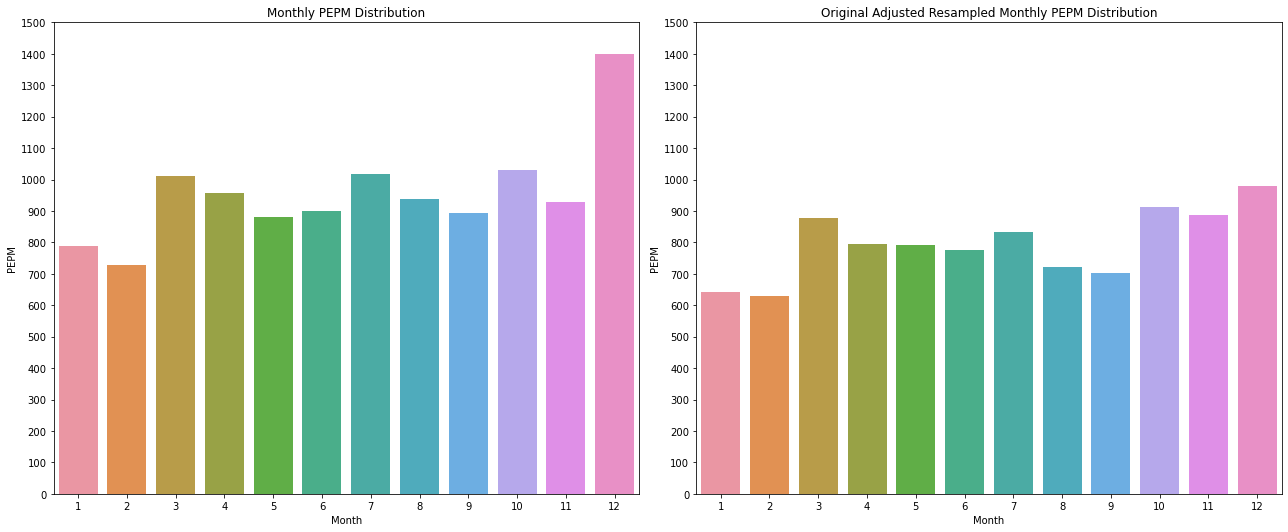

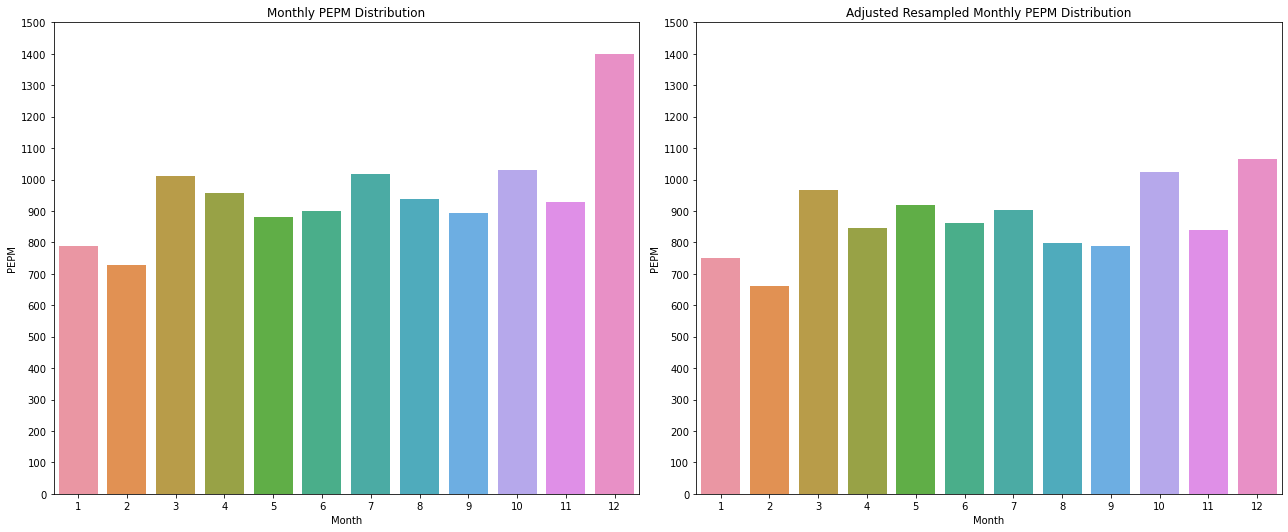

In [30]:
# Side-by-side mean monthly PEPM
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.groupby('Month').mean().reset_index(), x='Month', y='PEPM')
plt.xlabel('Month')
plt.yticks(np.arange(0, 1600, 100))
plt.title('Monthly PEPM Distribution')

plt.subplot(1, 2, 2)
sns.barplot(data=resampled_months.groupby('Month').mean().reset_index(), x='Month', y='PEPM')
plt.xlabel('Month')
plt.yticks(np.arange(0, 1600, 100))
plt.title('Original Adjusted Resampled Monthly PEPM Distribution')

plt.tight_layout()
plt.show()

# Side-by-side mean monthly PEPM
plt.figure(figsize=(18, 7.5))
plt.subplot(1, 2, 1)
sns.barplot(data=claims.groupby('Month').mean().reset_index(), x='Month', y='PEPM')
plt.xlabel('Month')
plt.yticks(np.arange(0, 1600, 100))
plt.title('Monthly PEPM Distribution')

plt.subplot(1, 2, 2)
sns.barplot(data=resampled_months2.groupby('Month').mean().reset_index(), x='Month', y='PEPM')
plt.xlabel('Month')
plt.yticks(np.arange(0, 1600, 100))
plt.title('Adjusted Resampled Monthly PEPM Distribution')

plt.tight_layout()
plt.show()

p-value: 0.489


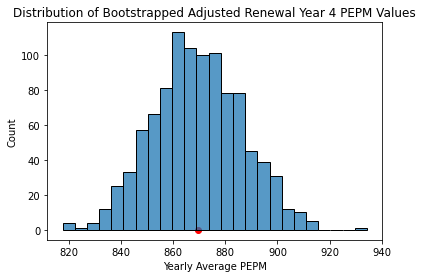

p-value: 0.494


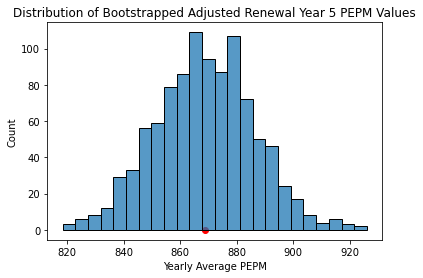

p-value: 0.494


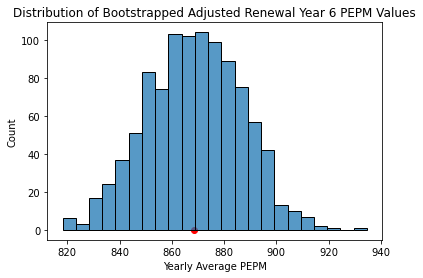

In [31]:
actual4, actual5, actual6 = [resampled_year_avg_pepm(resampled_months2, i, 1000) for i in np.arange(4, 7)]
pepms = [actual4, actual5, actual6]
plot_bootstrap_distributions(resampled_months2, pepms, 4)

Validation RMSE: 18.472525297341303
Test RMSE: 21.490741840326205
842.8194811148744
891.3686056272518
Alpha: 1.3896824343508338


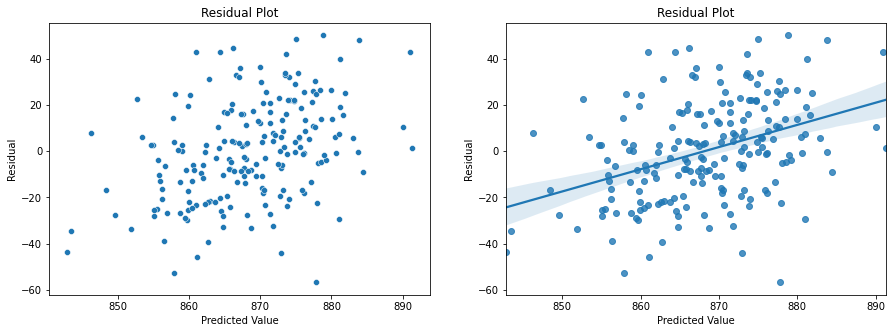

Correlation: 0.38834255521416444


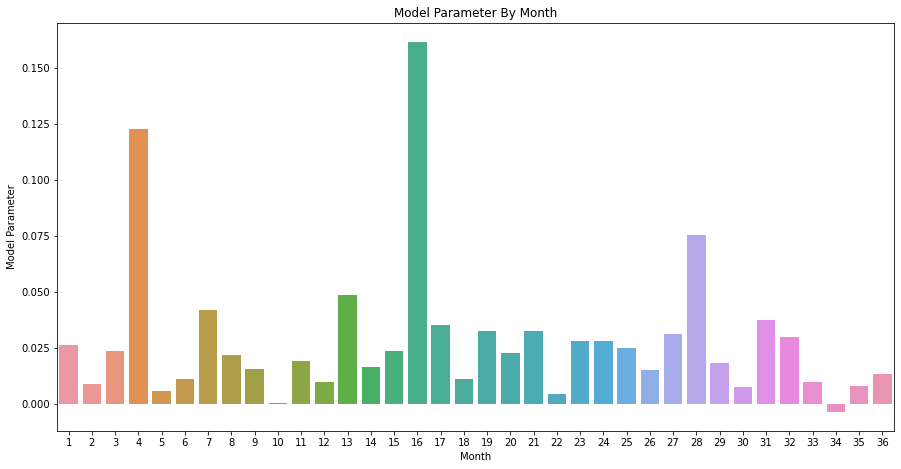

In [32]:
actual_pepm2 = resampled_year_avg_pepm(resampled_months2, 6, 1000)
    
renewal_yr1 = np.split(resampled_months2.query('`Renewal Year` == 3').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr2 = np.split(resampled_months2.query('`Renewal Year` == 4').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr3 = np.split(resampled_months2.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
design_matrix2 = pd.DataFrame(data={'Month 1': renewal_yr1[0], 'Month 2': renewal_yr1[1],
                                    'Month 3': renewal_yr1[2], 'Month 4': renewal_yr1[3],
                                    'Month 5': renewal_yr1[4], 'Month 6': renewal_yr1[5],
                                    'Month 7': renewal_yr1[6], 'Month 8': renewal_yr1[7],
                                    'Month 9': renewal_yr1[8], 'Month 10': renewal_yr1[9],
                                    'Month 11': renewal_yr1[10], 'Month 12': renewal_yr1[11],
                                    'Month 13': renewal_yr2[0], 'Month 14': renewal_yr2[1],
                                    'Month 15': renewal_yr2[2], 'Month 16': renewal_yr2[3],
                                    'Month 17': renewal_yr2[4], 'Month 18': renewal_yr2[5],
                                    'Month 19': renewal_yr2[6], 'Month 20': renewal_yr2[7],
                                    'Month 21': renewal_yr2[8], 'Month 22': renewal_yr2[9],
                                    'Month 23': renewal_yr2[10], 'Month 24':renewal_yr2[11],
                                    'Month 25': renewal_yr3[0], 'Month 26': renewal_yr3[1],
                                    'Month 27': renewal_yr3[2], 'Month 28': renewal_yr3[3],
                                    'Month 29': renewal_yr3[4], 'Month 30': renewal_yr3[5],
                                    'Month 31': renewal_yr3[6], 'Month 32': renewal_yr3[7],
                                    'Month 33': renewal_yr3[8], 'Month 34': renewal_yr3[9],
                                    'Month 35': renewal_yr3[10], 'Month 36': renewal_yr3[11],
                                    'Following Year Average PEPM': actual_pepm2})

# Model Selection
from sklearn import model_selection, linear_model

# Split into train and test sets
X2 = design_matrix2.drop('Following Year Average PEPM', axis=1)
Y2 = design_matrix2[['Following Year Average PEPM']]
X_train2, X_test2, Y_train2, Y_test2 = model_selection.train_test_split(X2, Y2, test_size=0.2)

# Training the model
lm = linear_model.LassoCV(eps=0.0000001, n_alphas=1000, fit_intercept=False, max_iter=100000, cv=10)
lm.fit(X_train2, Y_train2.values.flatten())

# Model validation
validation_predictions2 = lm.predict(X_train2)
test_predictions2 = lm.predict(X_test2)

model_validation_error2 = (np.mean((validation_predictions2 - Y_train2.values.flatten()) ** 2)) ** 0.5
model_test_error2 = (np.mean((test_predictions2 - Y_test2.values.flatten()) ** 2)) ** 0.5
print(f'Validation RMSE: {model_validation_error2}')
print(f'Test RMSE: {model_test_error2}')
print(min(test_predictions2.flatten()))
print(max(test_predictions2.flatten()))
print(f'Alpha: {lm.alpha_}')

# Plotting the residuals
residuals2 = test_predictions2.flatten() - Y_test2.values.flatten()
residuals_df2 = pd.DataFrame(data={'Predicted Value': test_predictions2.flatten(), 'Residual': residuals2})

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=residuals_df2, x='Predicted Value', y='Residual')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.regplot(data=residuals_df2, x='Predicted Value', y='Residual')
plt.title('Residual Plot')

plt.show()
print(f'Correlation: {residuals_df2.corr()["Residual"].values[0]}')

# Plotting model parameters
model_parameters = lm.coef_.flatten()
coefficients_df = pd.DataFrame(data={'Month': np.arange(1, 37), 'Coefficients': model_parameters})

plt.figure(figsize=(15, 7.5))
sns.barplot(data=coefficients_df, x='Month', y='Coefficients')
plt.xlabel('Month')
plt.ylabel('Model Parameter')
plt.title('Model Parameter By Month')
plt.show()

p-value: 0.491


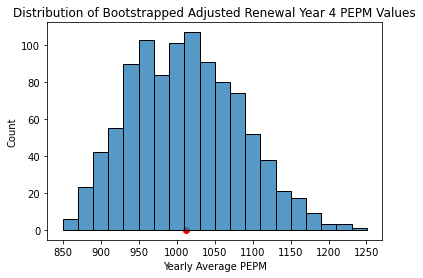

p-value: 0.498


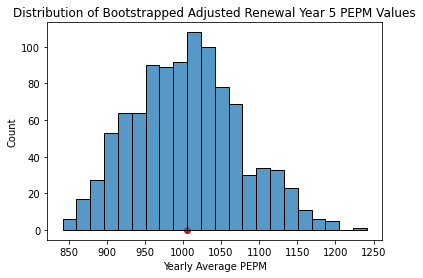

p-value: 0.485


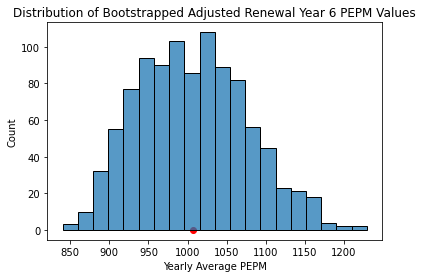

In [33]:
# Generating resamples
resampled_months3 = pd.DataFrame(columns=['Month',
                                          'Year'])
for num in np.arange(1, 13):
    for i in np.arange(1000):
        each_month = claims.query('Month == @num and Year >= 2017')
        month = [num, num, num, num, num]
        year = [2017, 2018, 2019, 2020, 2021]
        df = {'Month': month, 'Year': year}
        resampled = pd.DataFrame(data=df)
        resample = each_month[['EE Count', 'PEPM']].sample(frac=1, replace=True, axis=0).reset_index().drop('index', axis=1)
        resampled['EE Count'] = resample['EE Count']
        resampled['PEPM'] = resample['PEPM']
        resampled_months3 = resampled_months3.append(resampled)
resampled_months3 = resampled_months3.reset_index().drop('index', axis=1).dropna()

# Further data transformations
resampled_months3['Renewal Year'] = add_renewal_year(resampled_months3['Month'].values, \
                                                     resampled_months3['Year'].values)

pepm_ryr4 = resampled_year_avg_pepm(resampled_months3, 4, 1000)
pepm_ryr5 = resampled_year_avg_pepm(resampled_months3, 5, 1000)
pepm_ryr6 = resampled_year_avg_pepm(resampled_months3, 6, 1000)

actual4, actual5, actual6 = [resampled_year_avg_pepm(resampled_months3, i, 1000) for i in np.arange(4, 7)]
pepms = [actual4, actual5, actual6]
plot_bootstrap_distributions(resampled_months3, pepms, 4)

Validation RMSE: 73.7494498796997
Test RMSE: 71.8431863097826
928.6895995764833
1089.5940979416007
Alpha: 370.072158042821


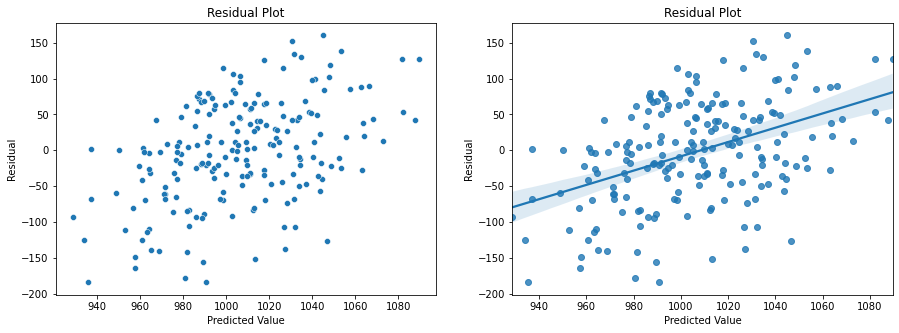

Correlation: 0.4425669947535529


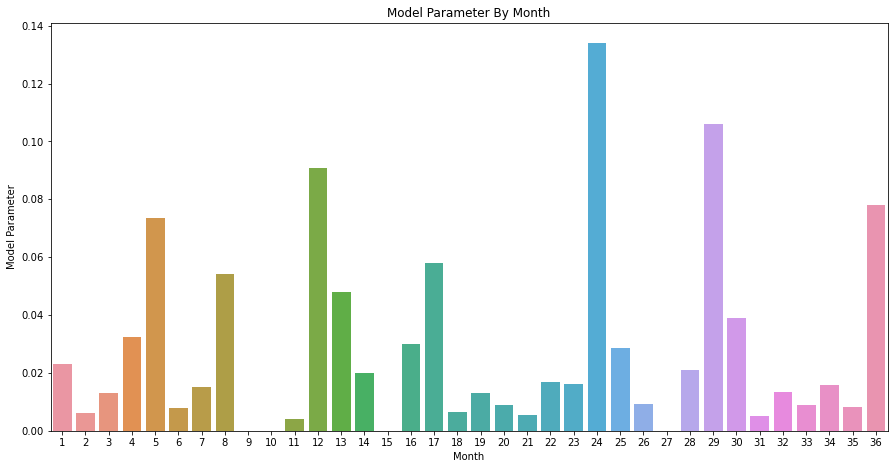

In [34]:
actual_pepm3 = resampled_year_avg_pepm(resampled_months3, 6, 1000)

renewal_yr1 = np.split(resampled_months3.query('`Renewal Year` == 3').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr2 = np.split(resampled_months3.query('`Renewal Year` == 4').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr3 = np.split(resampled_months3.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
design_matrix3 = pd.DataFrame(data={'Month 1': renewal_yr1[0], 'Month 2': renewal_yr1[1],
                                    'Month 3': renewal_yr1[2], 'Month 4': renewal_yr1[3],
                                    'Month 5': renewal_yr1[4], 'Month 6': renewal_yr1[5],
                                    'Month 7': renewal_yr1[6], 'Month 8': renewal_yr1[7],
                                    'Month 9': renewal_yr1[8], 'Month 10': renewal_yr1[9],
                                    'Month 11': renewal_yr1[10], 'Month 12': renewal_yr1[11],
                                    'Month 13': renewal_yr2[0], 'Month 14': renewal_yr2[1],
                                    'Month 15': renewal_yr2[2], 'Month 16': renewal_yr2[3],
                                    'Month 17': renewal_yr2[4], 'Month 18': renewal_yr2[5],
                                    'Month 19': renewal_yr2[6], 'Month 20': renewal_yr2[7],
                                    'Month 21': renewal_yr2[8], 'Month 22': renewal_yr2[9],
                                    'Month 23': renewal_yr2[10], 'Month 24':renewal_yr2[11],
                                    'Month 25': renewal_yr3[0], 'Month 26': renewal_yr3[1],
                                    'Month 27': renewal_yr3[2], 'Month 28': renewal_yr3[3],
                                    'Month 29': renewal_yr3[4], 'Month 30': renewal_yr3[5],
                                    'Month 31': renewal_yr3[6], 'Month 32': renewal_yr3[7],
                                    'Month 33': renewal_yr3[8], 'Month 34': renewal_yr3[9],
                                    'Month 35': renewal_yr3[10], 'Month 36': renewal_yr3[11],
                                    'Following Year Average PEPM': actual_pepm3})

# Model Selection
from sklearn import model_selection, linear_model

# Split into train and test sets
X3 = design_matrix3.drop('Following Year Average PEPM', axis=1)
Y3 = design_matrix3[['Following Year Average PEPM']]
X_train3, X_test3, Y_train3, Y_test3 = model_selection.train_test_split(X3, Y3, test_size=0.2)

# Training and fitting the model
l_model = linear_model.LassoCV(eps=0.0000001, n_alphas=1000, fit_intercept=False, max_iter=100000, cv=10)
l_model.fit(X_train3, Y_train3.values.flatten())
      

# Model validation
validation_predictions3 = l_model.predict(X_train3)
test_predictions3 = l_model.predict(X_test3)

model_validation_error3 = (np.mean((validation_predictions3 - Y_train3.values.flatten()) ** 2)) ** 0.5
model_test_error3 = (np.mean((test_predictions3 - Y_test3.values.flatten()) ** 2)) ** 0.5
print(f'Validation RMSE: {model_validation_error3}')
print(f'Test RMSE: {model_test_error3}')
print(min(test_predictions3.flatten()))
print(max(test_predictions3.flatten()))
print(f'Alpha: {l_model.alpha_}')

# Plotting the residuals
residuals3 = test_predictions3.flatten() - Y_test3.values.flatten()
residuals_df3 = pd.DataFrame(data={'Predicted Value': test_predictions3.flatten(), 'Residual': residuals3})

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=residuals_df3, x='Predicted Value', y='Residual')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
sns.regplot(data=residuals_df3, x='Predicted Value', y='Residual')
plt.title('Residual Plot')

plt.show()
print(f'Correlation: {residuals_df3.corr()["Residual"].values[0]}')

# Plotting the model parameters
model_parameters = l_model.coef_.flatten()
coefficients_df = pd.DataFrame(data={'Month': np.arange(1, 37), 'Coefficients': model_parameters})

plt.figure(figsize=(15, 7.5))
sns.barplot(data=coefficients_df, x='Month', y='Coefficients')
plt.xlabel('Month')
plt.ylabel('Model Parameter')
plt.title('Model Parameter By Month')
plt.show()

In [35]:
# Transform data
prediction_data = pd.read_csv('2019-2022 Data For Prediction.csv')
prediction_data['Total Expenses'] = prediction_data['Adjusted Paid Claims'] + prediction_data['Total Administration Fees']
prediction_data['PMPM'] = prediction_data['Total Expenses'] / prediction_data['Member Count']
prediction_data['PEPM'] = prediction_data['Total Expenses'] / prediction_data['EE Count']

renewal_yr5 = np.split(prediction_data.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr6 = np.split(prediction_data.query('`Renewal Year` == 6').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr7 = np.split(prediction_data.query('`Renewal Year` == 7').sort_values(['Year', 'Month'])['PEPM'].values, 12)
prediction_matrix = pd.DataFrame(data={'Month 1': renewal_yr5[0], 'Month 2': renewal_yr5[1],
                                       'Month 3': renewal_yr5[2], 'Month 4': renewal_yr5[3],
                                       'Month 5': renewal_yr5[4], 'Month 6': renewal_yr5[5],
                                       'Month 7': renewal_yr5[6], 'Month 8': renewal_yr5[7],
                                       'Month 9': renewal_yr5[8], 'Month 10': renewal_yr5[9],
                                       'Month 11': renewal_yr5[10], 'Month 12': renewal_yr5[11],
                                       'Month 13': renewal_yr6[0], 'Month 14': renewal_yr6[1],
                                       'Month 15': renewal_yr6[2], 'Month 16': renewal_yr6[3],
                                       'Month 17': renewal_yr6[4], 'Month 18': renewal_yr6[5],
                                       'Month 19': renewal_yr6[6], 'Month 20': renewal_yr6[7],
                                       'Month 21': renewal_yr6[8], 'Month 22': renewal_yr6[9],
                                       'Month 23': renewal_yr6[10], 'Month 24':renewal_yr6[11],
                                       'Month 25': renewal_yr7[0], 'Month 26': renewal_yr7[1],
                                       'Month 27': renewal_yr7[2], 'Month 28': renewal_yr7[3],
                                       'Month 29': renewal_yr7[4], 'Month 30': renewal_yr7[5],
                                       'Month 31': renewal_yr7[6], 'Month 32': renewal_yr7[7],
                                       'Month 33': renewal_yr7[8], 'Month 34': renewal_yr7[9],
                                       'Month 35': renewal_yr7[10], 'Month 36': renewal_yr7[11]})

prediction = model.predict(prediction_matrix).flatten()[0]
prediction2 = lm.predict(prediction_matrix).flatten()[0]
prediction3 = l_model.predict(prediction_matrix).flatten()[0]
ensemble_prediction = sum(np.array([prediction*0.5, prediction2*0.25, prediction3*0.25]))
print(f'First Model Prediction: {prediction.flatten()[0]}')
print(f'Second Model Prediction: {prediction2.flatten()[0]}')
print(f'Third Model Prediction: {prediction3.flatten()[0]}')
print(f'Ensemble Prediction: {ensemble_prediction}')

First Model Prediction: 970.5757914077393
Second Model Prediction: 989.163907965637
Third Model Prediction: 1015.0524357062834
Ensemble Prediction: 986.3419816218498


In [36]:
# Transform data
comparison_data = pd.read_csv('2018-2021 Data For Prediction.csv')
comparison_data['Total Expenses'] = comparison_data['Adjusted Paid Claims'] + comparison_data['Total Administration Fees']
comparison_data['PMPM'] = comparison_data['Total Expenses'] / comparison_data['Member Count']
comparison_data['PEPM'] = comparison_data['Total Expenses'] / comparison_data['EE Count']

# Comparing Models
renewal_yr4 = np.split(comparison_data.query('`Renewal Year` == 4').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr5 = np.split(comparison_data.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr6 = np.split(comparison_data.query('`Renewal Year` == 6').sort_values(['Year', 'Month'])['PEPM'].values, 12)
comparison_matrix = pd.DataFrame(data={'Month 1': renewal_yr4[0], 'Month 2': renewal_yr4[1],
                                       'Month 3': renewal_yr4[2], 'Month 4': renewal_yr4[3],
                                       'Month 5': renewal_yr4[4], 'Month 6': renewal_yr4[5],
                                       'Month 7': renewal_yr4[6], 'Month 8': renewal_yr4[7],
                                       'Month 9': renewal_yr4[8], 'Month 10': renewal_yr4[9],
                                       'Month 11': renewal_yr4[10], 'Month 12': renewal_yr4[11],
                                       'Month 13': renewal_yr5[0], 'Month 14': renewal_yr5[1],
                                       'Month 15': renewal_yr5[2], 'Month 16': renewal_yr5[3],
                                       'Month 17': renewal_yr5[4], 'Month 18': renewal_yr5[5],
                                       'Month 19': renewal_yr5[6], 'Month 20': renewal_yr5[7],
                                       'Month 21': renewal_yr5[8], 'Month 22': renewal_yr5[9],
                                       'Month 23': renewal_yr5[10], 'Month 24':renewal_yr5[11],
                                       'Month 25': renewal_yr6[0], 'Month 26': renewal_yr6[1],
                                       'Month 27': renewal_yr6[2], 'Month 28': renewal_yr6[3],
                                       'Month 29': renewal_yr6[4], 'Month 30': renewal_yr6[5],
                                       'Month 31': renewal_yr6[6], 'Month 32': renewal_yr6[7],
                                       'Month 33': renewal_yr6[8], 'Month 34': renewal_yr6[9],
                                       'Month 35': renewal_yr6[10], 'Month 36': renewal_yr6[11]})

comparison = model.predict(comparison_matrix).flatten()[0]
comparison2 = lm.predict(comparison_matrix).flatten()[0]
comparison3 = l_model.predict(comparison_matrix).flatten()[0]
ensemble_comparison = sum(np.array([comparison*0.4, comparison2*0.3, comparison3*0.3]))
print(f'First Model Prediction: {comparison.flatten()[0]}')
print(f'Second Model Prediction: {comparison2.flatten()[0]}')
print(f'Third Model Prediction: {comparison3.flatten()[0]}')
print(f'Ensemble Prediction: {ensemble_comparison}')

First Model Prediction: 1048.9423580521752
Second Model Prediction: 919.9724304087159
Third Model Prediction: 929.1717515702546
Ensemble Prediction: 974.3201978145612


In [37]:
renewal_yr4 = np.split(claims.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr5 = np.split(claims.query('`Renewal Year` == 6').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr6 = np.split(claims.query('`Renewal Year` == 7').sort_values(['Year', 'Month'])['PEPM'].values, 12)
claims_matrix = pd.DataFrame(data={'Month 1': renewal_yr4[0], 'Month 2': renewal_yr4[1],
                                   'Month 3': renewal_yr4[2], 'Month 4': renewal_yr4[3],
                                   'Month 5': renewal_yr4[4], 'Month 6': renewal_yr4[5],
                                   'Month 7': renewal_yr4[6], 'Month 8': renewal_yr4[7],
                                   'Month 9': renewal_yr4[8], 'Month 10': renewal_yr4[9],
                                   'Month 11': renewal_yr4[10], 'Month 12': renewal_yr4[11],
                                   'Month 13': renewal_yr5[0], 'Month 14': renewal_yr5[1],
                                   'Month 15': renewal_yr5[2], 'Month 16': renewal_yr5[3],
                                   'Month 17': renewal_yr5[4], 'Month 18': renewal_yr5[5],
                                   'Month 19': renewal_yr5[6], 'Month 20': renewal_yr5[7],
                                   'Month 21': renewal_yr5[8], 'Month 22': renewal_yr5[9],
                                   'Month 23': renewal_yr5[10], 'Month 24':renewal_yr5[11],
                                   'Month 25': renewal_yr6[0], 'Month 26': renewal_yr6[1],
                                   'Month 27': renewal_yr6[2], 'Month 28': renewal_yr6[3],
                                   'Month 29': renewal_yr6[4], 'Month 30': renewal_yr6[5],
                                   'Month 31': renewal_yr6[6], 'Month 32': renewal_yr6[7],
                                   'Month 33': renewal_yr6[8], 'Month 34': renewal_yr6[9],
                                   'Month 35': renewal_yr6[10], 'Month 36': renewal_yr6[11]})

claims_prediction = model.predict(claims_matrix).flatten()[0]
claims_prediction2 = lm.predict(claims_matrix).flatten()[0]
claims_prediction3 = l_model.predict(claims_matrix).flatten()[0]
ensemble_claims = sum(np.array([claims_prediction*0.6, claims_prediction2*0.25, claims_prediction3*0.15]))
print(f'First Model Prediction: {claims_prediction.flatten()[0]}')
print(f'Second Model Prediction: {claims_prediction2.flatten()[0]}')
print(f'Third Model Prediction: {claims_prediction3.flatten()[0]}')
print(f'Ensemble Prediction: {ensemble_claims}')

First Model Prediction: 970.5757914077393
Second Model Prediction: 989.163907965637
Third Model Prediction: 1015.0524357062834
Ensemble Prediction: 981.8943171919954


## Ensemble Model Testing

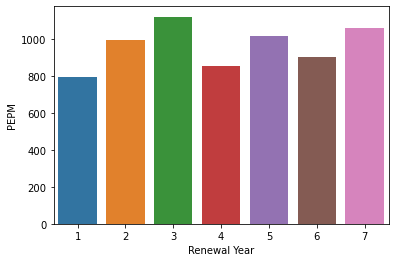

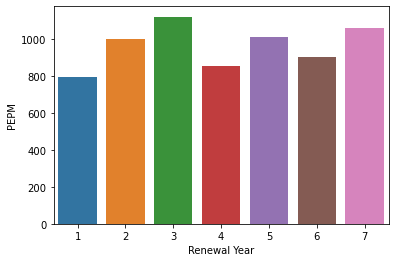

In [38]:
sns.barplot(data=claims.query('`Renewal Year` > 0').groupby('Renewal Year').mean().reset_index(), x='Renewal Year', y='PEPM')
plt.show()
avgs = np.array([])
for i in np.arange(1, 8):
    avg = calculate_weighted_avg(claims, i)
    avgs = np.append(avgs, avg)
sns.barplot(data=pd.DataFrame(data={'Renewal Year': np.arange(1, 8), 'PEPM': avgs}), x='Renewal Year', y='PEPM')
plt.show()

In [39]:
renewal_yr4 = np.split(claims.query('`Renewal Year` == 5').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr5 = np.split(claims.query('`Renewal Year` == 6').sort_values(['Year', 'Month'])['PEPM'].values, 12)
renewal_yr6 = np.split(claims.query('`Renewal Year` == 7').sort_values(['Year', 'Month'])['PEPM'].values, 12)
claims_matrix = pd.DataFrame(data={'Month 1': renewal_yr4[0], 'Month 2': renewal_yr4[1],
                                   'Month 3': renewal_yr4[2], 'Month 4': renewal_yr4[3],
                                   'Month 5': renewal_yr4[4], 'Month 6': renewal_yr4[5],
                                   'Month 7': renewal_yr4[6], 'Month 8': renewal_yr4[7],
                                   'Month 9': renewal_yr4[8], 'Month 10': renewal_yr4[9],
                                   'Month 11': renewal_yr4[10], 'Month 12': renewal_yr4[11],
                                   'Month 13': renewal_yr5[0], 'Month 14': renewal_yr5[1],
                                   'Month 15': renewal_yr5[2], 'Month 16': renewal_yr5[3],
                                   'Month 17': renewal_yr5[4], 'Month 18': renewal_yr5[5],
                                   'Month 19': renewal_yr5[6], 'Month 20': renewal_yr5[7],
                                   'Month 21': renewal_yr5[8], 'Month 22': renewal_yr5[9],
                                   'Month 23': renewal_yr5[10], 'Month 24':renewal_yr5[11],
                                   'Month 25': renewal_yr6[0], 'Month 26': renewal_yr6[1],
                                   'Month 27': renewal_yr6[2], 'Month 28': renewal_yr6[3],
                                   'Month 29': renewal_yr6[4], 'Month 30': renewal_yr6[5],
                                   'Month 31': renewal_yr6[6], 'Month 32': renewal_yr6[7],
                                   'Month 33': renewal_yr6[8], 'Month 34': renewal_yr6[9],
                                   'Month 35': renewal_yr6[10], 'Month 36': renewal_yr6[11]})

claims_prediction = model.predict(claims_matrix).flatten()[0]
claims_prediction2 = lm.predict(claims_matrix).flatten()[0]
claims_prediction3 = l_model.predict(claims_matrix).flatten()[0]
ensemble_claims = sum(np.array([claims_prediction*0.34, claims_prediction2*0.33, claims_prediction3*0.33]))
calculated_weighted_average = calculate_weighted_avg(claims, 7)
print(f'First Model Prediction: {claims_prediction.flatten()[0]}')
print(f'Second Model Prediction: {claims_prediction2.flatten()[0]}')
print(f'Third Model Prediction: {claims_prediction3.flatten()[0]}')
print(f'Ensemble Prediction: {ensemble_claims}')
#print(f'Random Forest Prediction: {random_forest.predict(claims_matrix).flatten()[0]}')
#print(f'Random Forest Max-Depth 5 Prediction: {random_forest_max5.predict(claims_matrix).flatten()[0]}')
#print(f'Random Forest Max-Depth 10 Prediction: {random_forest_max10.predict(claims_matrix).flatten()[0]}')
#print(f'Random Forest Max-Depth 15 Prediction: {random_forest_max15.predict(claims_matrix).flatten()[0]}')
print(f'Actual Weighted Average: {calculated_weighted_average}')

First Model Prediction: 970.5757914077393
Second Model Prediction: 989.163907965637
Third Model Prediction: 1015.0524357062834
Ensemble Prediction: 991.3871624903652
Actual Weighted Average: 1056.7557363866329


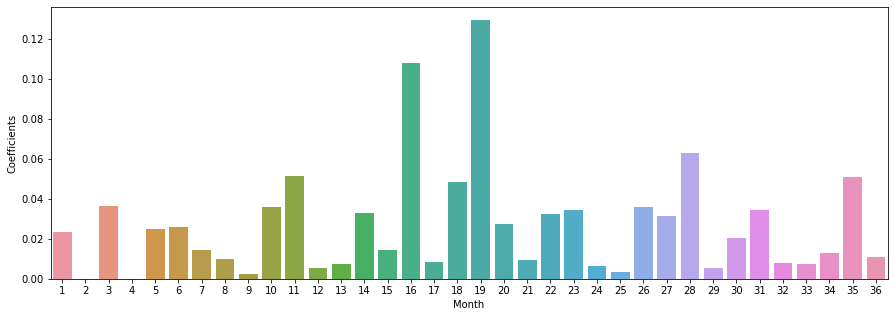

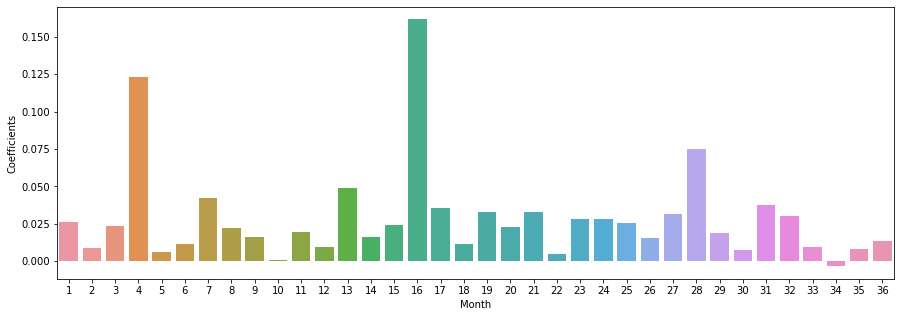

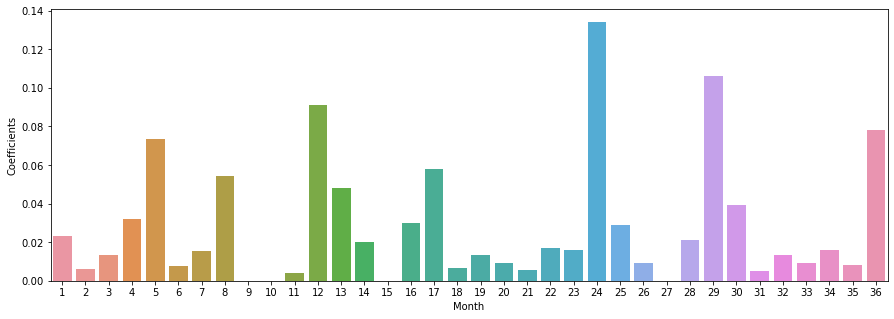

In [40]:
months = np.arange(1, 37)
plt.figure(figsize=(15, 5))
sns.barplot(data=pd.DataFrame(data={'Coefficients': model.coef_.flatten(), 'Month': months}), x='Month', y='Coefficients')
plt.show()
plt.figure(figsize=(15, 5))
sns.barplot(data=pd.DataFrame(data={'Coefficients': lm.coef_.flatten(), 'Month': months}), x='Month', y='Coefficients')
plt.show()
plt.figure(figsize=(15, 5))
sns.barplot(data=pd.DataFrame(data={'Coefficients': l_model.coef_.flatten(), 'Month': months}), x='Month', y='Coefficients')
plt.show()

In [41]:
# Optimize ensemble model weighting
from scipy import optimize

def ensemble_error_calc(weights):
    '''
    Function that calculates the total RMSE for the original claims dataset
    -----
    Input:
    
    weights (List-like/iterable) - Ensemble model weights 
    -----
    Output:
    
    total_RMSE (float) - Sum of the RMSEs
    '''
    rmses = np.array([])
    model_1 = weights[0]
    model_2 = weights[1]
    model_3 = weights[2]
    for i in np.arange(1, 3):
        renewal_yr1 = np.split(claims.query('`Renewal Year` == @i').sort_values(['Year', 'Month'])['PEPM'].values, 12)
        renewal_yr2 = np.split(claims.query('`Renewal Year` == @i + 1').sort_values(['Year', 'Month'])['PEPM'].values, 12)
        renewal_yr3 = np.split(claims.query('`Renewal Year` == @i + 2').sort_values(['Year', 'Month'])['PEPM'].values, 12)
        matrix = pd.DataFrame(data={'Month 1': renewal_yr1[0], 'Month 2': renewal_yr1[1],
                                    'Month 3': renewal_yr1[2], 'Month 4': renewal_yr1[3],
                                    'Month 5': renewal_yr1[4], 'Month 6': renewal_yr1[5],
                                    'Month 7': renewal_yr1[6], 'Month 8': renewal_yr1[7],
                                    'Month 9': renewal_yr1[8], 'Month 10': renewal_yr1[9],
                                    'Month 11': renewal_yr1[10], 'Month 12': renewal_yr1[11],
                                    'Month 13': renewal_yr2[0], 'Month 14': renewal_yr2[1],
                                    'Month 15': renewal_yr2[2], 'Month 16': renewal_yr2[3],
                                    'Month 17': renewal_yr2[4], 'Month 18': renewal_yr2[5],
                                    'Month 19': renewal_yr2[6], 'Month 20': renewal_yr2[7],
                                    'Month 21': renewal_yr2[8], 'Month 22': renewal_yr2[9],
                                    'Month 23': renewal_yr2[10], 'Month 24':renewal_yr2[11],
                                    'Month 25': renewal_yr3[0], 'Month 26': renewal_yr3[1],
                                    'Month 27': renewal_yr3[2], 'Month 28': renewal_yr3[3],
                                    'Month 29': renewal_yr3[4], 'Month 30': renewal_yr3[5],
                                    'Month 31': renewal_yr3[6], 'Month 32': renewal_yr3[7],
                                    'Month 33': renewal_yr3[8], 'Month 34': renewal_yr3[9],
                                    'Month 35': renewal_yr3[10], 'Month 36': renewal_yr3[11]})
        model_prediction = model.predict(matrix)
        lm_prediction = lm.predict(matrix)
        l_model_prediction = l_model.predict(matrix)
        ensemble_prediction = sum(np.array([model_prediction * model_1, 
                                            lm_prediction * model_2, 
                                            l_model_prediction * model_3]))
        actual_pepm = calculate_weighted_avg(claims, i + 3)
        one_rmse = np.mean((ensemble_prediction - actual_pepm) ** 2) ** 0.5
        rmses = np.append(rmses, one_rmse)
    total_RMSE= sum(rmses)
    return total_RMSE

non_negative = ((0, None), (0, None), (0, None))
min_obj = optimize.minimize(ensemble_error_calc, np.array([0.34, 0.33, 0.33]), bounds=non_negative)
ensemble_weights = min_obj.x / sum(min_obj.x)
display(ensemble_weights)
min_obj

array([0.9200266, 0.0799734, 0.       ])

      fun: 49.51711148539471
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-129.70198148,  -44.44046911,  -17.39736035])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 564
      nit: 11
     njev: 141
   status: 2
  success: False
        x: array([0.83131895, 0.07226248, 0.        ])

In [42]:
def ensemble_predict(weights, start_year):
    '''
    Calculates ensemble PEPM prediction given weighting weights and initial year start_year
    -----
    Inputs:
    
    weights (NumPy Array) - Array of length three with the weights for model,
                            lm, and l_model respectively
                            
    start_year (int) - Int value specifying the start year
    -----
    Output:
    
    ensemble_prediction (float) - Predicted PEPM value from the ensemble model
    '''
    model_1 = weights[0]
    model_2 = weights[1]
    model_3 = weights[2]
    renewal_yr1 = np.split(claims.query('`Renewal Year` == @start_year').sort_values(['Year', 'Month'])['PEPM'].values, 12)
    renewal_yr2 = np.split(claims.query('`Renewal Year` == @start_year + 1').sort_values(['Year', 'Month'])['PEPM'].values, 12)
    renewal_yr3 = np.split(claims.query('`Renewal Year` == @start_year + 2').sort_values(['Year', 'Month'])['PEPM'].values, 12)
    matrix = pd.DataFrame(data={'Month 1': renewal_yr1[0], 'Month 2': renewal_yr1[1],
                                'Month 3': renewal_yr1[2], 'Month 4': renewal_yr1[3],
                                'Month 5': renewal_yr1[4], 'Month 6': renewal_yr1[5],
                                'Month 7': renewal_yr1[6], 'Month 8': renewal_yr1[7],
                                'Month 9': renewal_yr1[8], 'Month 10': renewal_yr1[9],
                                'Month 11': renewal_yr1[10], 'Month 12': renewal_yr1[11],
                                'Month 13': renewal_yr2[0], 'Month 14': renewal_yr2[1],
                                'Month 15': renewal_yr2[2], 'Month 16': renewal_yr2[3],
                                'Month 17': renewal_yr2[4], 'Month 18': renewal_yr2[5],
                                'Month 19': renewal_yr2[6], 'Month 20': renewal_yr2[7],
                                'Month 21': renewal_yr2[8], 'Month 22': renewal_yr2[9],
                                'Month 23': renewal_yr2[10], 'Month 24':renewal_yr2[11],
                                'Month 25': renewal_yr3[0], 'Month 26': renewal_yr3[1],
                                'Month 27': renewal_yr3[2], 'Month 28': renewal_yr3[3],
                                'Month 29': renewal_yr3[4], 'Month 30': renewal_yr3[5],
                                'Month 31': renewal_yr3[6], 'Month 32': renewal_yr3[7],
                                'Month 33': renewal_yr3[8], 'Month 34': renewal_yr3[9],
                                'Month 35': renewal_yr3[10], 'Month 36': renewal_yr3[11]}) 
    model_prediction = model.predict(matrix)
    lm_prediction = lm.predict(matrix)
    l_model_prediction = l_model.predict(matrix)
    ensemble_prediction = sum(np.array([model_prediction * model_1, 
                                        lm_prediction * model_2, 
                                        l_model_prediction * model_3]))[0]
    return ensemble_prediction
print(f'Model Prediction: {ensemble_predict([1, 0, 0], 5)}')
print(f'Lm Prediction: {ensemble_predict([0, 1, 0], 5)}')
print(f'L_model Prediction: {ensemble_predict([0, 0, 1], 5)}')
print(f'Ensemble Prediction: {ensemble_predict(ensemble_weights, 5)}')
print(f'Actual Weighted Average: {calculate_weighted_avg(claims, 3)}')
print(f'Total RMSE for model: {ensemble_error_calc([1, 0, 0])}')
print(f'Total RMSE for lm: {ensemble_error_calc([0, 1, 0])}')
print(f'Total RMSE for l_model: {ensemble_error_calc([0, 0, 1])}')
print(f'Total RMSE for rigorous ensemble model: {ensemble_error_calc(ensemble_weights)}')

Model Prediction: 970.5757914077393
Lm Prediction: 989.163907965637
L_model Prediction: 1015.0524357062834
Ensemble Prediction: 972.0623462844258
Actual Weighted Average: 1119.4055295658682
Total RMSE for model: 260.8955682221389
Total RMSE for lm: 169.7039298515681
Total RMSE for l_model: 143.1548546859982
Total RMSE for rigorous ensemble model: 253.60266286991782


## Random Forest Approach

In [43]:
from sklearn import model_selection, ensemble

# Split the data
X = design_matrix2.drop('Following Year Average PEPM', axis=1)
Y = design_matrix2['Following Year Average PEPM']
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2)

# Create the RandomForestRegressor Object
random_forest = ensemble.RandomForestRegressor()
random_forest_max5 = ensemble.RandomForestRegressor(max_depth=5)
random_forest_max10 = ensemble.RandomForestRegressor(max_depth=10)
random_forest_max15 = ensemble.RandomForestRegressor(max_depth=15)

# Training the models
random_forest.fit(X_train, Y_train)
random_forest_max5.fit(X_train, Y_train)
random_forest_max10.fit(X_train, Y_train)
random_forest_max15.fit(X_train, Y_train)

# Validating the models
predictions = random_forest.predict(X_train)
fitted = random_forest.predict(X_test)
predictions5 = random_forest_max5.predict(X_train)
fitted_max5 = random_forest_max5.predict(X_test)
predictions10 = random_forest_max10.predict(X_train)
fitted_max10 = random_forest_max10.predict(X_test)
predictions15 = random_forest_max15.predict(X_train)
fitted_max15 = random_forest_max15.predict(X_test)
print(f'Random Forest Validation RMSE: {np.mean((predictions - Y_train) ** 2) ** 0.5}')
print(f'Random Forest Test RMSE: {np.mean((fitted - Y_test) ** 2) ** 0.5}')
print(f'Random Forest Max-Depth 5 Validation RMSE: {np.mean((predictions5 - Y_train) ** 2) ** 0.5}')
print(f'Random Forest Max-Depth 5 Test RMSE: {np.mean((fitted_max5 - Y_test) ** 2) ** 0.5}')
print(f'Random Forest Max-Depth 10 Validation RMSE: {np.mean((predictions10 - Y_train) ** 2) ** 0.5}')
print(f'Random Forest Max-Depth 10 Test RMSE: {np.mean((fitted_max10 - Y_test) ** 2) ** 0.5}')
print(f'Random Forest Max-Depth 15 Validation RMSE: {np.mean((predictions15 - Y_train) ** 2) ** 0.5}')
print(f'Random Forest Max-Depth 15 Test RMSE: {np.mean((fitted_max15 - Y_test) ** 2) ** 0.5}')

Random Forest Validation RMSE: 6.975791934054628
Random Forest Test RMSE: 18.6100044432083
Random Forest Max-Depth 5 Validation RMSE: 14.62130674765099
Random Forest Max-Depth 5 Test RMSE: 18.03097735447027
Random Forest Max-Depth 10 Validation RMSE: 7.715770884566538
Random Forest Max-Depth 10 Test RMSE: 18.035019643399462
Random Forest Max-Depth 15 Validation RMSE: 6.839917813433454
Random Forest Max-Depth 15 Test RMSE: 18.204325397601107
